# Pretrained Models

## Imports and Data

In [45]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import models, datasets, transforms
from torch import nn, optim
from sklearn.model_selection import train_test_split

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)), #resize the image to 224x224
    transforms.ToTensor(),  #convert the image to a pytorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #normalize the image
])

Dataset using Sams data and tested on teachers given data

In [48]:
dataset = datasets.ImageFolder(root='./dataset/dataset', transform=data_transform)

class_names = dataset.classes

train_size = 0.80
val_size = 0.20


#dataset given by teacher

testData = datasets.ImageFolder(root='./FoodDatasetComplete', transform=data_transform)


# Split indices into training and combined validation/test indices
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=(val_size), random_state=42)


train_set = Subset(dataset, train_indices)  # Subset for training datata
test_set = testData               # Subset for validation data given by teacher
val_set = Subset(dataset, val_indices)    # Subset for test data
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

Data set tested on just teachers data

In [49]:
#dataset tests for only teacher data
'''
teachers_Data = datasets.ImageFolder(root='./FoodDatasetComplete', transform=data_transform)

test_ratio = 0.15
train_ratio = 0.7
val_ratio = 0.15

# Split indices into training and combined validation/test indices
train_indices, val_test_indices = train_test_split(range(len(teachers_Data)), test_size=(test_ratio + val_ratio), random_state=42)

# Split indices into validation and test indices
val_indices, test_indices = train_test_split(val_test_indices, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

train_set = Subset(teachers_Data, train_indices)  # Subset for training data
val_set = Subset(teachers_Data, val_indices)      # Subset for validation data
test_set = Subset(teachers_Data, test_indices)    # Subset for test data
'''

"\nteachers_Data = datasets.ImageFolder(root='./FoodDatasetComplete', transform=data_transform)\n\ntest_ratio = 0.15\ntrain_ratio = 0.7\nval_ratio = 0.15\n\n# Split indices into training and combined validation/test indices\ntrain_indices, val_test_indices = train_test_split(range(len(teachers_Data)), test_size=(test_ratio + val_ratio), random_state=42)\n\n# Split indices into validation and test indices\nval_indices, test_indices = train_test_split(val_test_indices, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)\n\ntrain_set = Subset(teachers_Data, train_indices)  # Subset for training data\nval_set = Subset(teachers_Data, val_indices)      # Subset for validation data\ntest_set = Subset(teachers_Data, test_indices)    # Subset for test data\n"

## Model Functions

In [50]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=5, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [51]:
def trainModel(model, setepochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    custom_callback = CustomCallback()
    custom_callback.set_optimizer(optimizer)
    model.to(device)
    custom_callback.set_model(model)
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)
    train_losses = []  # List to store training losses
    train_accuracies = []  # List to store training accuracies
    val_losses = []  # List to store validation losses
    val_accuracies = []  # List to store validation accuracies

    # Training loop
    num_epochs = setepochs  # Number of epochs for training
    for epoch in range(num_epochs):
        # Training
        model.train()  # Set the model to training mode
        running_train_loss = 0.0  # Initialize running training loss
        correct_train = 0  # Initialize number of correctly predicted training samples
        total_train = 0  # Initialize total number of training samples
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize parameters

            running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_train += labels.size(0)  # Increment total training samples
            correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

        # Calculate epoch-wise training loss and accuracy
        epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
        train_accuracy = correct_train / total_train  # Training accuracy

        # Validation
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0  # Initialize running validation loss
        correct_val = 0  # Initialize number of correctly predicted validation samples
        total_val = 0  # Initialize total number of validation samples
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
                outputs = model(inputs)  # Forward pass
                if isinstance(outputs, tuple):
                    logits = outputs[0]  # Unpack logits if model returns tuple
                else:
                    logits = outputs
                loss = criterion(logits, labels)  # Calculate loss

                running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
                _, predicted = torch.max(logits, 1)  # Get predicted labels
                total_val += labels.size(0)  # Increment total validation samples
                correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

        # Calculate epoch-wise validation loss and accuracy
        epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
        val_accuracy = correct_val / total_val  # Validation accuracy

        # Append values to lists
        train_losses.append(epoch_train_loss)  # Append training loss
        train_accuracies.append(train_accuracy)  # Append training accuracy
        val_losses.append(epoch_val_loss)  # Append validation loss
        val_accuracies.append(val_accuracy)  # Append validation accuracy

        # Step LR scheduler
        lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

        # Check early stopping
        if custom_callback.on_epoch_end(epoch, epoch_val_loss):
            break  # Stop training if early stopping criterion is met

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Plot training and validation losses starting from index 1
    epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

    # Plot training and validation accuracies
    plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
    plt.xlabel('Epoch')  # Set label for the x-axis
    plt.ylabel('Accuracy')  # Set label for the y-axis
    plt.title('Training and Validation Accuracies')  # Set title for the plot
    plt.legend()  # Display legend
    plt.show()  # Show the plot
    # Plot training and validation losses starting from index 1
    epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

    # Plot training and validation losses
    plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
    plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
    plt.xlabel('Epoch')  # Set label for the x-axis
    plt.ylabel('Loss')  # Set label for the y-axis
    plt.title('Training and Validation Losses')  # Set title for the plot
    plt.legend()  # Display legend
    plt.grid(True)  # Display grid
    plt.show()  # Show the plot

In [52]:
def evalModel(model, criterion):
    model.eval()  # Set model to evaluation mode
    test_correct = 0  # Initialize number of correctly predicted samples
    test_total = 0  # Initialize total number of samples
    test_running_loss = 0.0  # Initialize running test loss

    with torch.no_grad():  # Turn off gradients during evaluation
        for inputs, labels in test_loader:  # Iterate through test data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)  # Get model predictions
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits from model outputs if necessary
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            test_total += labels.size(0)  # Update total number of samples
            test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

    # Calculate test loss and accuracy
    test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
    test_accuracy = test_correct / test_total  # Test accuracy

    # Print test results
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

## GoogLeNet

### Model

#### Load Model

In [53]:
default_weight_googlenet = models.GoogLeNet_Weights.DEFAULT
googlenet_model = models.googlenet(weights=default_weight_googlenet)

In [54]:
for param in googlenet_model.parameters():
    param.requires_grad = False

In [55]:
num_ftrs = googlenet_model.fc.in_features
googlenet_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_googlenet_model = googlenet_model


#### Training


In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)), #resize the image to 224x224
    transforms.ToTensor(),  #convert the image to a pytorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #normalize the image
])

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 3.5950, Train Accuracy: 0.1453, Val Loss: 3.4806, Val Accuracy: 0.2593
Epoch [2/10], Train Loss: 3.3790, Train Accuracy: 0.3695, Val Loss: 3.3335, Val Accuracy: 0.4096
Epoch [3/10], Train Loss: 3.2962, Train Accuracy: 0.4470, Val Loss: 3.3008, Val Accuracy: 0.4322
Epoch [4/10], Train Loss: 3.2416, Train Accuracy: 0.4985, Val Loss: 3.2758, Val Accuracy: 0.4641
Epoch [5/10], Train Loss: 3.2206, Train Accuracy: 0.5165, Val Loss: 3.2607, Val Accuracy: 0.4761
Epoch [6/10], Train Loss: 3.2059, Train Accuracy: 0.5304, Val Loss: 3.2570, Val Accuracy: 0.4774
Epoch [7/10], Train Loss: 3.1999, Train Accuracy: 0.5334, Val Loss: 3.2566, Val Accuracy: 0.4774
Epoch [8/10], Train Loss: 3.1888, Train Accuracy: 0.5487, Val Loss: 3.2440, Val Accuracy: 0.4947
Epoch [9/10], Train Loss: 3.1800, Train Accuracy: 0.5534, Val Loss: 3.2238, Val Accuracy: 0.5146
Epoch [10/10], Train Loss: 3.1675, Train Accuracy: 0.5677, Val Loss: 3.2063, Val Accuracy: 0.5293


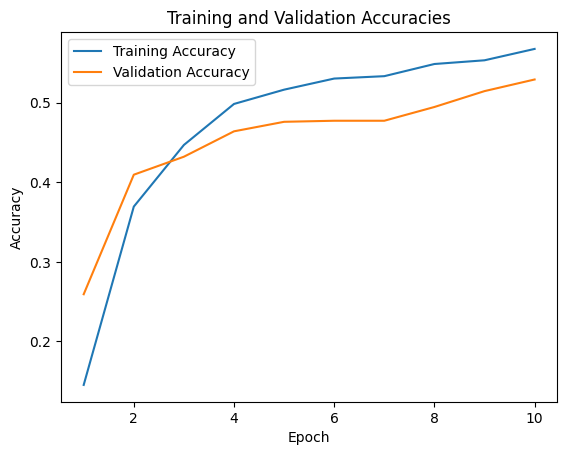

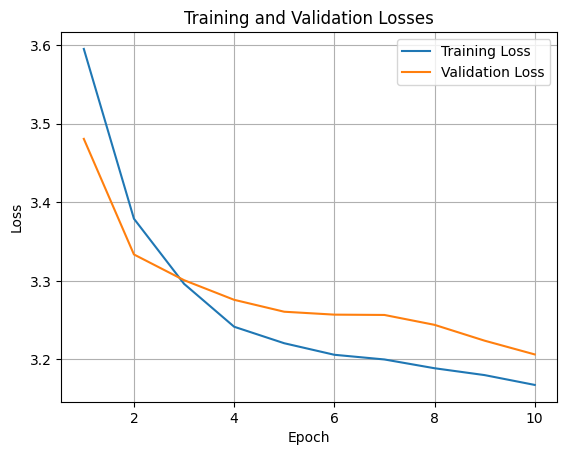

In [56]:
trainModel(tuned_googlenet_model, 10)

In [57]:
evalModel(tuned_googlenet_model, nn.CrossEntropyLoss())

Test Loss: 3.5869, Test Accuracy: 0.1399


## MobileNet V3

### Model Small

#### Load Model

In [58]:
default_weight_mobilenet = models.MobileNet_V3_Small_Weights.DEFAULT
mobilenet_model = models.mobilenet_v3_small(weights=default_weight_mobilenet)

In [59]:
# Freeze all layers
for param in mobilenet_model.parameters():
    param.requires_grad = False

In [60]:
num_features = mobilenet_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_mobilenet_model = mobilenet_model

tuned_mobilenet_model.classifier = new_head



#### Training

Epoch [1/10], Train Loss: 3.5462, Train Accuracy: 0.2049, Val Loss: 3.4124, Val Accuracy: 0.3351
Epoch [2/10], Train Loss: 3.3467, Train Accuracy: 0.3951, Val Loss: 3.3585, Val Accuracy: 0.3750
Epoch [3/10], Train Loss: 3.3086, Train Accuracy: 0.4320, Val Loss: 3.3270, Val Accuracy: 0.4069
Epoch [4/10], Train Loss: 3.2531, Train Accuracy: 0.4839, Val Loss: 3.2537, Val Accuracy: 0.4827
Epoch [5/10], Train Loss: 3.1983, Train Accuracy: 0.5407, Val Loss: 3.1984, Val Accuracy: 0.5412
Epoch [6/10], Train Loss: 3.1473, Train Accuracy: 0.5873, Val Loss: 3.1979, Val Accuracy: 0.5386
Epoch [7/10], Train Loss: 3.1355, Train Accuracy: 0.6009, Val Loss: 3.1785, Val Accuracy: 0.5572
Epoch [8/10], Train Loss: 3.1172, Train Accuracy: 0.6196, Val Loss: 3.1735, Val Accuracy: 0.5612
Epoch [9/10], Train Loss: 3.0996, Train Accuracy: 0.6349, Val Loss: 3.1616, Val Accuracy: 0.5718
Epoch [10/10], Train Loss: 3.0914, Train Accuracy: 0.6425, Val Loss: 3.1499, Val Accuracy: 0.5851


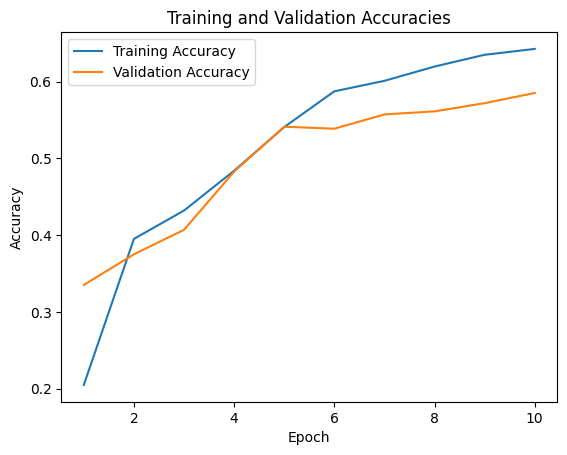

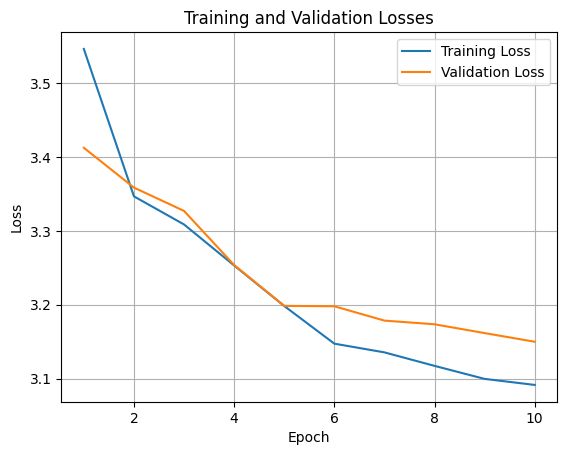

In [61]:
trainModel(tuned_mobilenet_model, 10)

In [62]:
evalModel(tuned_mobilenet_model, nn.CrossEntropyLoss())

Test Loss: 3.6162, Test Accuracy: 0.1119


### Model Large

#### Load Model

In [63]:
default_weight_mobilenet_Large = models.MobileNet_V3_Large_Weights.DEFAULT
mobilenet_large_model = models.mobilenet_v3_large(weights=default_weight_mobilenet_Large)

In [64]:
# Freeze all layers
for param in mobilenet_large_model.parameters():
    param.requires_grad = False

In [65]:
num_features = mobilenet_large_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_mobilenet_large_model = mobilenet_large_model


tuned_mobilenet_large_model.classifier = new_head


#### Training


Epoch [1/10], Train Loss: 3.4734, Train Accuracy: 0.2890, Val Loss: 3.2799, Val Accuracy: 0.4654
Epoch [2/10], Train Loss: 3.1799, Train Accuracy: 0.5713, Val Loss: 3.1482, Val Accuracy: 0.5824
Epoch [3/10], Train Loss: 3.0772, Train Accuracy: 0.6691, Val Loss: 3.0783, Val Accuracy: 0.6596
Epoch [4/10], Train Loss: 3.0238, Train Accuracy: 0.7157, Val Loss: 3.0509, Val Accuracy: 0.6902
Epoch [5/10], Train Loss: 3.0073, Train Accuracy: 0.7286, Val Loss: 3.0481, Val Accuracy: 0.6915
Epoch [6/10], Train Loss: 3.0049, Train Accuracy: 0.7296, Val Loss: 3.0627, Val Accuracy: 0.6676
Epoch [7/10], Train Loss: 2.9863, Train Accuracy: 0.7502, Val Loss: 3.0370, Val Accuracy: 0.6915
Epoch [8/10], Train Loss: 2.9752, Train Accuracy: 0.7582, Val Loss: 3.0242, Val Accuracy: 0.7088
Epoch [9/10], Train Loss: 2.9666, Train Accuracy: 0.7665, Val Loss: 3.0253, Val Accuracy: 0.7114
Epoch [10/10], Train Loss: 2.9651, Train Accuracy: 0.7679, Val Loss: 3.0196, Val Accuracy: 0.7128


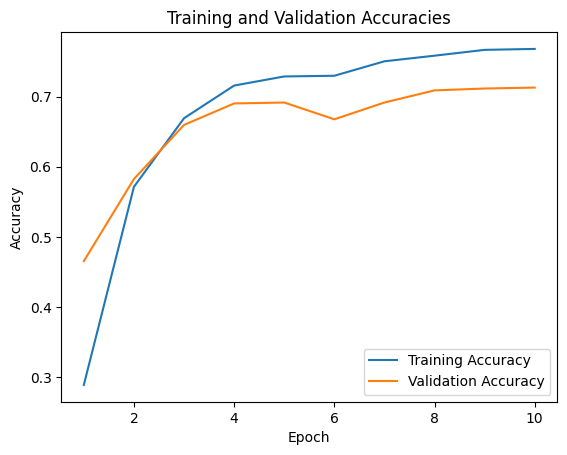

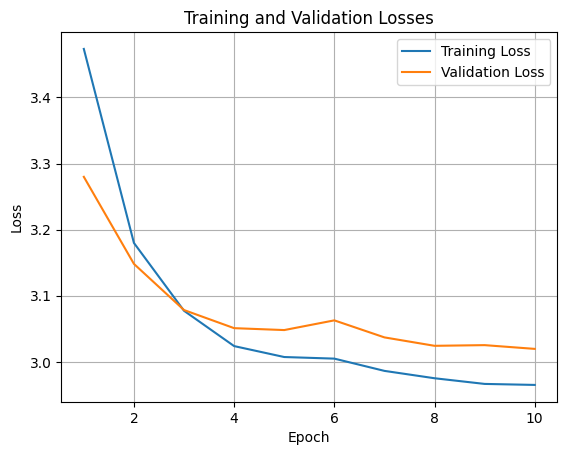

In [66]:
trainModel(tuned_mobilenet_large_model, 10)

In [67]:
evalModel(tuned_mobilenet_large_model, nn.CrossEntropyLoss())

Test Loss: 3.5934, Test Accuracy: 0.1399


## AlexNet

### Load Model

In [68]:
default_weight_AlexNet = models.AlexNet_Weights.DEFAULT
alexnet_model = models.alexnet(weights=default_weight_AlexNet)

In [69]:
#freeze all layers
for param in alexnet_model.parameters():
    param.requires_grad = False

In [70]:
num_features = alexnet_model.classifier[6].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_alexnet_model = alexnet_model

tuned_alexnet_model.classifier[6] = new_head



In [71]:
print(tuned_alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Training


Epoch [1/10], Train Loss: 3.3745, Train Accuracy: 0.3671, Val Loss: 3.2529, Val Accuracy: 0.4787
Epoch [2/10], Train Loss: 3.2108, Train Accuracy: 0.5221, Val Loss: 3.1929, Val Accuracy: 0.5452
Epoch [3/10], Train Loss: 3.1623, Train Accuracy: 0.5700, Val Loss: 3.1624, Val Accuracy: 0.5691
Epoch [4/10], Train Loss: 3.1290, Train Accuracy: 0.6043, Val Loss: 3.1414, Val Accuracy: 0.5904
Epoch [5/10], Train Loss: 3.1084, Train Accuracy: 0.6235, Val Loss: 3.1596, Val Accuracy: 0.5745
Epoch [6/10], Train Loss: 3.0983, Train Accuracy: 0.6335, Val Loss: 3.1365, Val Accuracy: 0.5931
Epoch [7/10], Train Loss: 3.0832, Train Accuracy: 0.6478, Val Loss: 3.1304, Val Accuracy: 0.5971
Epoch [8/10], Train Loss: 3.0680, Train Accuracy: 0.6641, Val Loss: 3.1158, Val Accuracy: 0.6157
Epoch [9/10], Train Loss: 3.0606, Train Accuracy: 0.6708, Val Loss: 3.1102, Val Accuracy: 0.6210
Epoch [10/10], Train Loss: 3.0559, Train Accuracy: 0.6741, Val Loss: 3.0979, Val Accuracy: 0.6316


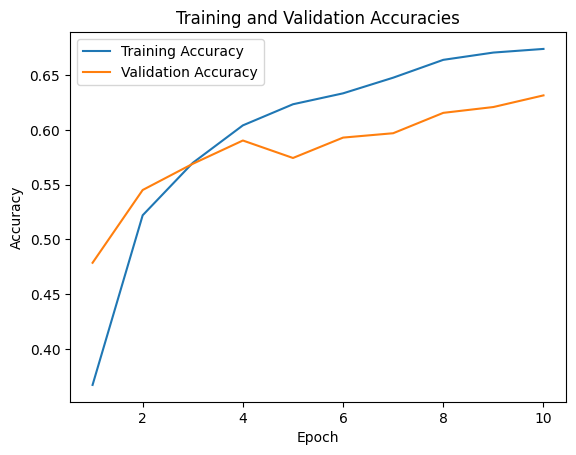

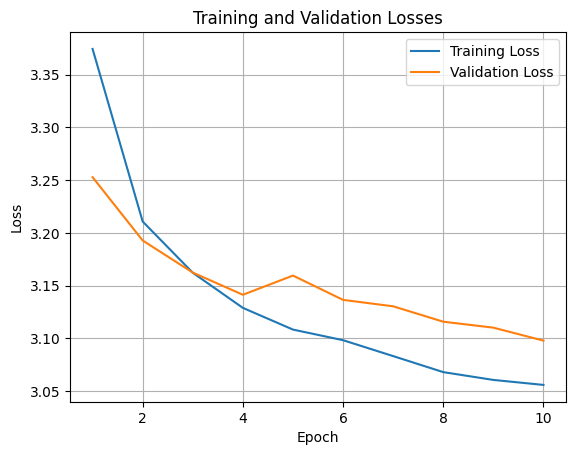

In [72]:
trainModel(tuned_alexnet_model, 10)

In [73]:
evalModel(tuned_alexnet_model, nn.CrossEntropyLoss())

Test Loss: 3.6118, Test Accuracy: 0.1189


## ConvNeXt

### Models


#### Tiny

##### Load Model

In [74]:
default_weight_ConvNeXt_tiny = models.ConvNeXt_Tiny_Weights.DEFAULT
convnext_tiny_model = models.convnext_tiny(weights=default_weight_ConvNeXt_tiny)

In [75]:
#freeze all layers
for param in convnext_tiny_model.parameters():
    param.requires_grad = False

In [76]:
num_features = convnext_tiny_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_convnext_tiny_model = convnext_tiny_model

tuned_convnext_tiny_model.classifier[2] = new_head

In [77]:
print(tuned_convnext_tiny_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

##### Training 


Epoch [1/10], Train Loss: 3.3509, Train Accuracy: 0.4280, Val Loss: 3.0965, Val Accuracy: 0.6463
Epoch [2/10], Train Loss: 3.0759, Train Accuracy: 0.6638, Val Loss: 3.0331, Val Accuracy: 0.7021
Epoch [3/10], Train Loss: 3.0215, Train Accuracy: 0.7150, Val Loss: 2.9972, Val Accuracy: 0.7340
Epoch [4/10], Train Loss: 2.9854, Train Accuracy: 0.7499, Val Loss: 2.9772, Val Accuracy: 0.7593
Epoch [5/10], Train Loss: 2.9582, Train Accuracy: 0.7735, Val Loss: 2.9601, Val Accuracy: 0.7726
Epoch [6/10], Train Loss: 2.9506, Train Accuracy: 0.7822, Val Loss: 2.9575, Val Accuracy: 0.7779
Epoch [7/10], Train Loss: 2.9485, Train Accuracy: 0.7832, Val Loss: 2.9576, Val Accuracy: 0.7753
Epoch [8/10], Train Loss: 2.9298, Train Accuracy: 0.8028, Val Loss: 2.9227, Val Accuracy: 0.8152
Epoch [9/10], Train Loss: 2.9025, Train Accuracy: 0.8307, Val Loss: 2.9214, Val Accuracy: 0.8072
Epoch [10/10], Train Loss: 2.8970, Train Accuracy: 0.8341, Val Loss: 2.9215, Val Accuracy: 0.8125


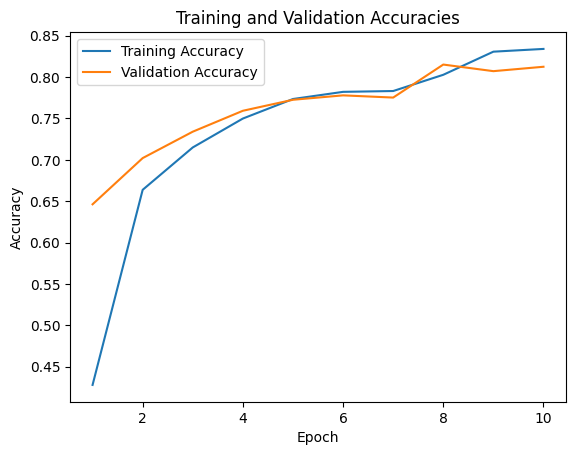

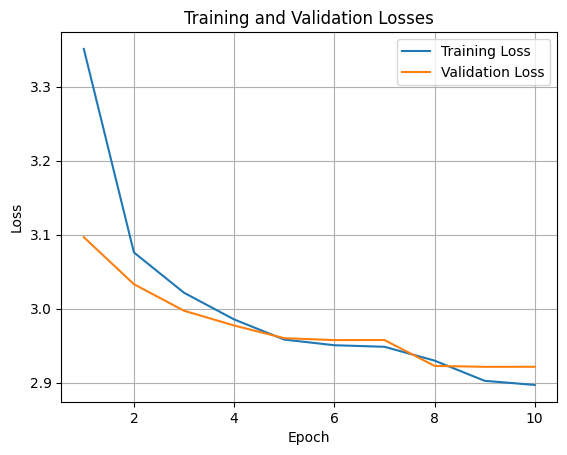

In [78]:
trainModel(tuned_convnext_tiny_model, 10)

In [79]:
evalModel(tuned_convnext_tiny_model, nn.CrossEntropyLoss())

Test Loss: 3.5121, Test Accuracy: 0.2308


#### Small


##### Load Model


In [80]:
default_weight_ConvNeXt_small = models.ConvNeXt_Small_Weights.DEFAULT
convnext_small_model = models.convnext_small(weights=default_weight_ConvNeXt_small)

In [81]:
#freeze all layers
for param in convnext_small_model.parameters():
    param.requires_grad = False

In [82]:
num_features = convnext_small_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_convnext_small_model = convnext_small_model

tuned_convnext_small_model.classifier[2] = new_head

In [83]:
print(tuned_convnext_small_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

##### Training


Epoch [1/10], Train Loss: 3.3930, Train Accuracy: 0.3688, Val Loss: 3.1647, Val Accuracy: 0.5731
Epoch [2/10], Train Loss: 3.1465, Train Accuracy: 0.5906, Val Loss: 3.1323, Val Accuracy: 0.6011
Epoch [3/10], Train Loss: 3.1200, Train Accuracy: 0.6132, Val Loss: 3.1171, Val Accuracy: 0.6170
Epoch [4/10], Train Loss: 3.1088, Train Accuracy: 0.6235, Val Loss: 3.1049, Val Accuracy: 0.6290
Epoch [5/10], Train Loss: 3.0810, Train Accuracy: 0.6508, Val Loss: 3.0894, Val Accuracy: 0.6410
Epoch [6/10], Train Loss: 3.0580, Train Accuracy: 0.6768, Val Loss: 3.0533, Val Accuracy: 0.6782
Epoch [7/10], Train Loss: 3.0383, Train Accuracy: 0.6944, Val Loss: 3.0611, Val Accuracy: 0.6715
Epoch [8/10], Train Loss: 3.0392, Train Accuracy: 0.6911, Val Loss: 3.0460, Val Accuracy: 0.6875
Epoch [9/10], Train Loss: 3.0184, Train Accuracy: 0.7140, Val Loss: 3.0357, Val Accuracy: 0.6995
Epoch [10/10], Train Loss: 3.0186, Train Accuracy: 0.7123, Val Loss: 3.0345, Val Accuracy: 0.6955


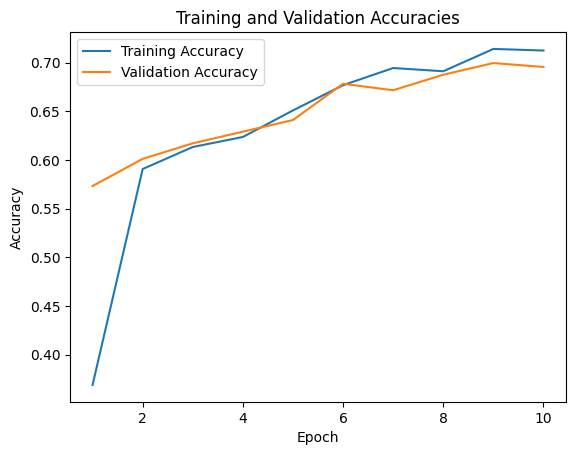

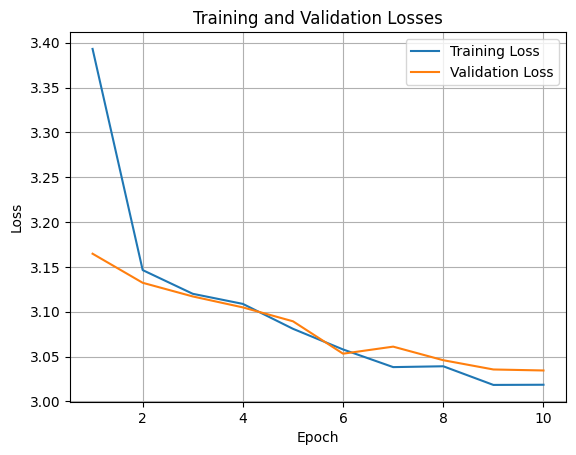

In [84]:
trainModel(tuned_convnext_small_model, 10)

In [85]:
evalModel(tuned_convnext_small_model, nn.CrossEntropyLoss())

Test Loss: 3.6058, Test Accuracy: 0.1259


#### Base

##### Load Model

In [86]:
default_weight_ConvNeXt_base = models.ConvNeXt_Base_Weights.DEFAULT
convnext_base_model = models.convnext_base(weights=default_weight_ConvNeXt_base)

In [87]:
#freeze all layers
for param in convnext_base_model.parameters():
    param.requires_grad = False

In [88]:
num_features = convnext_base_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_convnext_base_model = convnext_base_model\

tuned_convnext_base_model.classifier[2] = new_head

tuned_convnext_base_model = convnext_base_model

In [89]:
print(tuned_convnext_base_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

##### Training

Epoch [1/10], Train Loss: 3.3749, Train Accuracy: 0.4014, Val Loss: 3.1296, Val Accuracy: 0.6170
Epoch [2/10], Train Loss: 3.0790, Train Accuracy: 0.6605, Val Loss: 3.0863, Val Accuracy: 0.6529
Epoch [3/10], Train Loss: 3.0480, Train Accuracy: 0.6864, Val Loss: 3.0682, Val Accuracy: 0.6622
Epoch [4/10], Train Loss: 3.0415, Train Accuracy: 0.6907, Val Loss: 3.0758, Val Accuracy: 0.6569
Epoch [5/10], Train Loss: 3.0356, Train Accuracy: 0.6984, Val Loss: 3.0534, Val Accuracy: 0.6809
Epoch [6/10], Train Loss: 3.0097, Train Accuracy: 0.7240, Val Loss: 3.0220, Val Accuracy: 0.7101
Epoch [7/10], Train Loss: 2.9749, Train Accuracy: 0.7582, Val Loss: 3.0118, Val Accuracy: 0.7194
Epoch [8/10], Train Loss: 2.9611, Train Accuracy: 0.7719, Val Loss: 2.9937, Val Accuracy: 0.7367
Epoch [9/10], Train Loss: 2.9581, Train Accuracy: 0.7739, Val Loss: 2.9934, Val Accuracy: 0.7394
Epoch [10/10], Train Loss: 2.9605, Train Accuracy: 0.7705, Val Loss: 2.9924, Val Accuracy: 0.7394


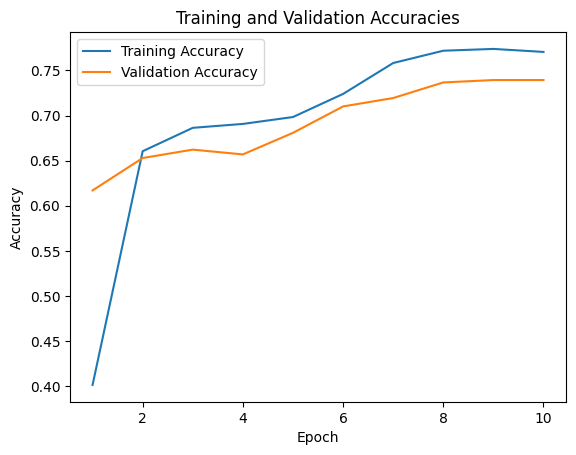

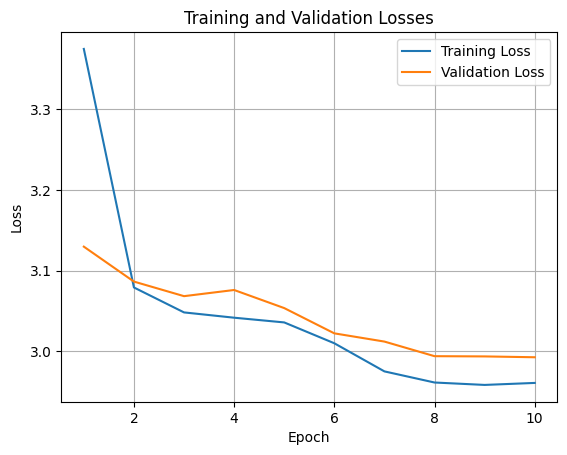

In [90]:
trainModel(tuned_convnext_base_model, 10)

In [91]:
evalModel(tuned_convnext_base_model, nn.CrossEntropyLoss())

Test Loss: 3.5811, Test Accuracy: 0.1469


#### Large

##### Load Model

In [92]:
default_weight_ConvNeXt_large = models.ConvNeXt_Large_Weights.DEFAULT
convnext_large_model = models.convnext_large(weights=default_weight_ConvNeXt_large)

In [93]:
#freeze all layers
for param in convnext_large_model.parameters():
    param.requires_grad = False

In [94]:
num_features = convnext_large_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_convnext_large_model = convnext_large_model

tuned_convnext_large_model.classifier[2] = new_head



In [95]:
print(tuned_convnext_base_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

##### Training

Epoch [1/10], Train Loss: 3.3575, Train Accuracy: 0.4423, Val Loss: 3.1568, Val Accuracy: 0.5851
Epoch [2/10], Train Loss: 3.0987, Train Accuracy: 0.6395, Val Loss: 3.1059, Val Accuracy: 0.6263
Epoch [3/10], Train Loss: 3.0683, Train Accuracy: 0.6661, Val Loss: 3.0778, Val Accuracy: 0.6582
Epoch [4/10], Train Loss: 3.0201, Train Accuracy: 0.7140, Val Loss: 3.0258, Val Accuracy: 0.7141
Epoch [5/10], Train Loss: 2.9775, Train Accuracy: 0.7549, Val Loss: 3.0091, Val Accuracy: 0.7234
Epoch [6/10], Train Loss: 2.9554, Train Accuracy: 0.7788, Val Loss: 2.9725, Val Accuracy: 0.7633
Epoch [7/10], Train Loss: 2.9293, Train Accuracy: 0.8041, Val Loss: 2.9694, Val Accuracy: 0.7606
Epoch [8/10], Train Loss: 2.9198, Train Accuracy: 0.8138, Val Loss: 2.9623, Val Accuracy: 0.7686
Epoch [9/10], Train Loss: 2.9151, Train Accuracy: 0.8178, Val Loss: 2.9566, Val Accuracy: 0.7726
Epoch [10/10], Train Loss: 2.8996, Train Accuracy: 0.8341, Val Loss: 2.9383, Val Accuracy: 0.7992


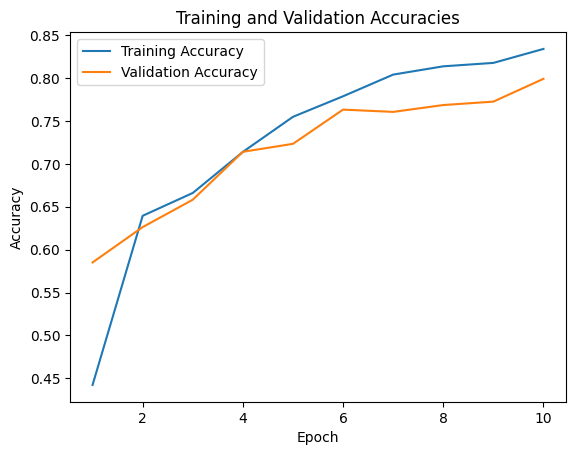

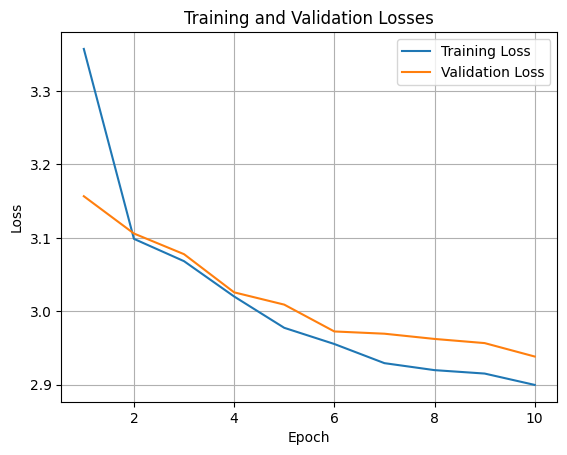

In [96]:
trainModel(tuned_convnext_large_model, 10)

In [97]:
evalModel(tuned_convnext_large_model, nn.CrossEntropyLoss())

Test Loss: 3.5188, Test Accuracy: 0.2238


## EfficientNetV2

### Models

#### Small


##### Load Model

In [107]:
default_weight_EfficientNetV2_small = models.EfficientNet_V2_S_Weights.DEFAULT
efficientnetv2_small_model = models.efficientnet_v2_s(weights=default_weight_EfficientNetV2_small)

In [108]:
for param in efficientnetv2_small_model.parameters():
    param.requires_grad = False

In [109]:
num_features = efficientnetv2_small_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_efficientnetv2_small_model = efficientnetv2_small_model


tuned_efficientnetv2_small_model.classifier = new_head

In [110]:
print(tuned_efficientnetv2_small_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 3.4682, Train Accuracy: 0.3033, Val Loss: 3.2597, Val Accuracy: 0.4920
Epoch [2/10], Train Loss: 3.1916, Train Accuracy: 0.5520, Val Loss: 3.1855, Val Accuracy: 0.5598
Epoch [3/10], Train Loss: 3.1108, Train Accuracy: 0.6315, Val Loss: 3.0910, Val Accuracy: 0.6609
Epoch [4/10], Train Loss: 3.0476, Train Accuracy: 0.6964, Val Loss: 3.0665, Val Accuracy: 0.6689
Epoch [5/10], Train Loss: 3.0277, Train Accuracy: 0.7090, Val Loss: 3.0608, Val Accuracy: 0.6702
Epoch [6/10], Train Loss: 3.0061, Train Accuracy: 0.7300, Val Loss: 3.0340, Val Accuracy: 0.6981
Epoch [7/10], Train Loss: 2.9938, Train Accuracy: 0.7426, Val Loss: 3.0367, Val Accuracy: 0.6928
Epoch [8/10], Train Loss: 2.9846, Train Accuracy: 0.7499, Val Loss: 3.0147, Val Accuracy: 0.7247
Epoch [9/10], Train Loss: 2.9806, Train Accuracy: 0.7536, Val Loss: 3.0067, Val Accuracy: 0.7234
Epoch [10/10], Train Loss: 2.9707, Train Accuracy: 0.7649, Val Loss: 3.0007, Val Accuracy: 0.7327


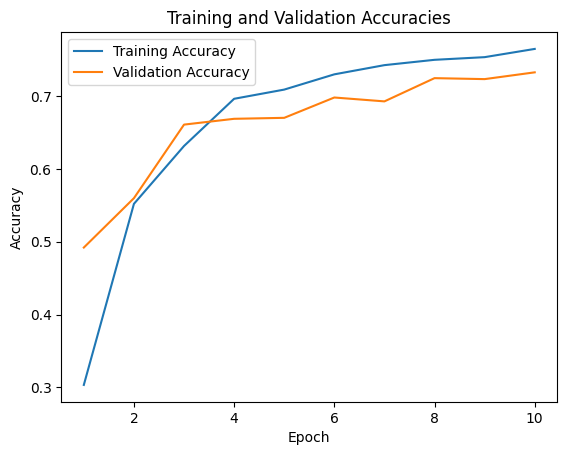

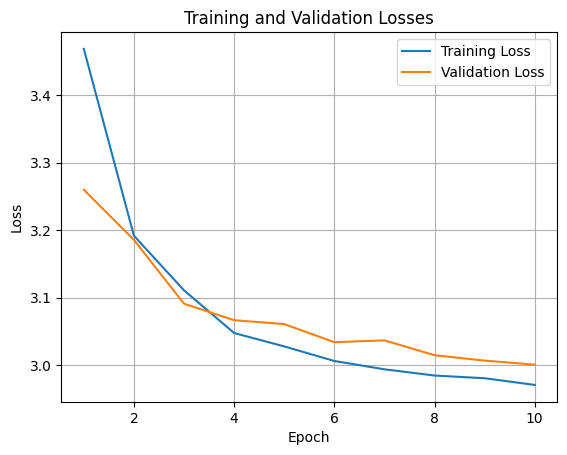

In [111]:
trainModel(tuned_efficientnetv2_small_model, 10)

In [103]:
evalModel(tuned_efficientnetv2_small_model, nn.CrossEntropyLoss())

Test Loss: 3.5985, Test Accuracy: 0.1329


#### Medium


##### Load Model

In [112]:
default_weight_EfficientNetV2_medium = models.EfficientNet_V2_M_Weights.DEFAULT
efficientnetv2_medium_model = models.efficientnet_v2_m(weights=default_weight_EfficientNetV2_medium)

In [113]:
for param in efficientnetv2_medium_model.parameters():
    param.requires_grad = False

In [114]:
num_features = efficientnetv2_medium_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_efficientnetv2_medium_model = efficientnetv2_medium_model

tuned_efficientnetv2_medium_model.classifier = new_head

In [115]:
print(tuned_efficientnetv2_medium_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

##### Training


Epoch [1/10], Train Loss: 3.4354, Train Accuracy: 0.3502, Val Loss: 3.2826, Val Accuracy: 0.4508
Epoch [2/10], Train Loss: 3.2107, Train Accuracy: 0.5344, Val Loss: 3.1860, Val Accuracy: 0.5505
Epoch [3/10], Train Loss: 3.1617, Train Accuracy: 0.5763, Val Loss: 3.1673, Val Accuracy: 0.5718
Epoch [4/10], Train Loss: 3.1481, Train Accuracy: 0.5890, Val Loss: 3.1622, Val Accuracy: 0.5718
Epoch [5/10], Train Loss: 3.1367, Train Accuracy: 0.5996, Val Loss: 3.1507, Val Accuracy: 0.5785
Epoch [6/10], Train Loss: 3.1222, Train Accuracy: 0.6122, Val Loss: 3.1390, Val Accuracy: 0.5971
Epoch [7/10], Train Loss: 3.1032, Train Accuracy: 0.6319, Val Loss: 3.1215, Val Accuracy: 0.6077
Epoch [8/10], Train Loss: 3.0735, Train Accuracy: 0.6605, Val Loss: 3.1145, Val Accuracy: 0.6184
Epoch [9/10], Train Loss: 3.0698, Train Accuracy: 0.6615, Val Loss: 3.1018, Val Accuracy: 0.6316
Epoch [10/10], Train Loss: 3.0518, Train Accuracy: 0.6804, Val Loss: 3.0943, Val Accuracy: 0.6370


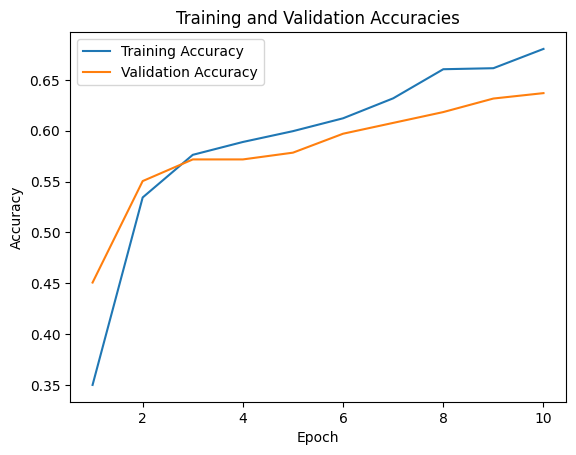

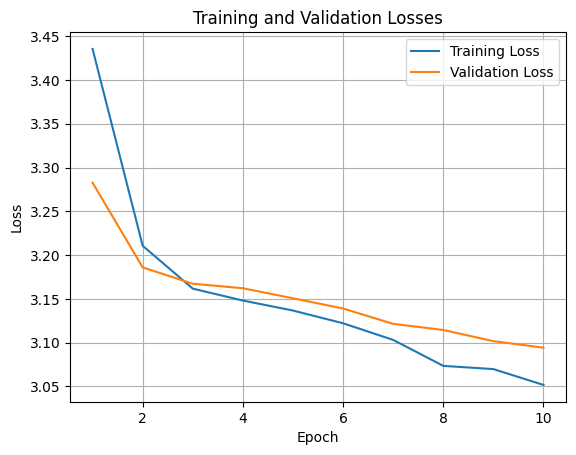

In [116]:
trainModel(tuned_efficientnetv2_medium_model, 10)

In [117]:
evalModel(tuned_efficientnetv2_medium_model, nn.CrossEntropyLoss())

Test Loss: 3.5902, Test Accuracy: 0.1399


#### Large 

##### Load Model

In [118]:
default_weight_EfficientNetV2_large = models.EfficientNet_V2_L_Weights.DEFAULT
efficientnetv2_large_model = models.efficientnet_v2_l(weights=default_weight_EfficientNetV2_large)

In [119]:
for param in efficientnetv2_large_model.parameters():
    param.requires_grad = False

In [120]:
num_features = efficientnetv2_large_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_efficientnetv2_large_model = efficientnetv2_large_model

tuned_efficientnetv2_large_model.classifier = new_head

In [121]:
print(tuned_efficientnetv2_large_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

##### Training

Epoch [1/10], Train Loss: 3.4974, Train Accuracy: 0.2514, Val Loss: 3.2712, Val Accuracy: 0.4907
Epoch [2/10], Train Loss: 3.2246, Train Accuracy: 0.5168, Val Loss: 3.1986, Val Accuracy: 0.5492
Epoch [3/10], Train Loss: 3.1467, Train Accuracy: 0.5936, Val Loss: 3.1091, Val Accuracy: 0.6316
Epoch [4/10], Train Loss: 3.0971, Train Accuracy: 0.6372, Val Loss: 3.0939, Val Accuracy: 0.6436
Epoch [5/10], Train Loss: 3.0932, Train Accuracy: 0.6412, Val Loss: 3.0926, Val Accuracy: 0.6410
Epoch [6/10], Train Loss: 3.0857, Train Accuracy: 0.6462, Val Loss: 3.0964, Val Accuracy: 0.6356
Epoch [7/10], Train Loss: 3.0608, Train Accuracy: 0.6721, Val Loss: 3.0638, Val Accuracy: 0.6715
Epoch [8/10], Train Loss: 3.0331, Train Accuracy: 0.6994, Val Loss: 3.0638, Val Accuracy: 0.6676
Epoch [9/10], Train Loss: 3.0372, Train Accuracy: 0.6954, Val Loss: 3.0617, Val Accuracy: 0.6676
Epoch [10/10], Train Loss: 3.0123, Train Accuracy: 0.7213, Val Loss: 3.0379, Val Accuracy: 0.6941


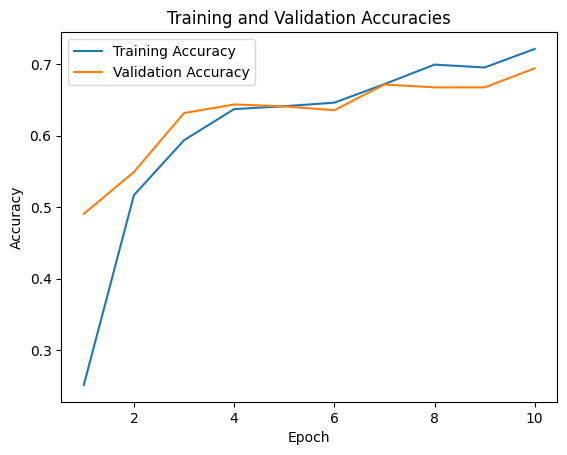

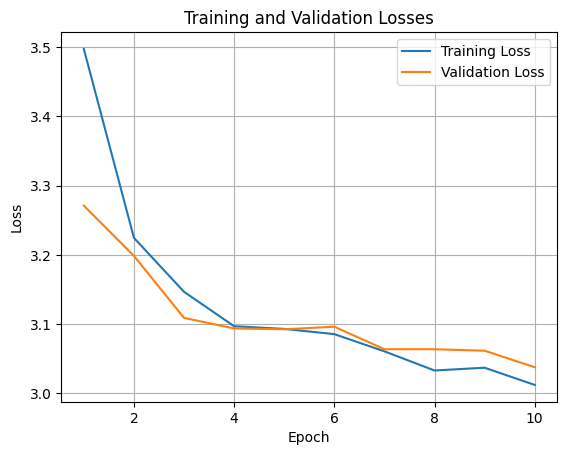

In [122]:
trainModel(tuned_efficientnetv2_large_model, 10)

In [123]:
evalModel(tuned_efficientnetv2_large_model, nn.CrossEntropyLoss())

Test Loss: 3.5474, Test Accuracy: 0.1678


## InceptionV3

### Load Model


In [172]:
default_weight_inceptionV3 = models.Inception_V3_Weights.DEFAULT
inceptionv3_model = models.inception_v3(weights=default_weight_inceptionV3)

In [173]:
#freeze all layers
for param in inceptionv3_model.parameters():
    param.requires_grad = False

In [189]:
num_features = inceptionv3_model.fc[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_inceptionv3_model = inceptionv3_model

tuned_inceptionv3_model.fc = new_head

## turned aux_logits off because size of input is less then 299x299
tuned_inceptionv3_model.aux_logits = False

In [190]:
print(tuned_inceptionv3_model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

### Training

In [191]:
trainModel(tuned_inceptionv3_model, 10)

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [181]:
evalModel(tuned_inceptionv3_model, nn.CrossEntropyLoss())

Test Loss: 3.6258, Test Accuracy: 0.1049


## DenseNet

### Models

#### DenseNet121

##### Load Model

In [182]:
default_weight_densenet121 = models.DenseNet121_Weights.DEFAULT
densenet121_model = models.densenet121(weights=default_weight_densenet121)

In [183]:
for param in densenet121_model.parameters():
    param.requires_grad = False

In [185]:
num_features = densenet121_model.classifier.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_densenet121_model = densenet121_model

tuned_densenet121_model.classifier = new_head

In [186]:
print(tuned_densenet121_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

##### Training

In [187]:
trainModel(tuned_densenet121_model, 10)

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
evalModel(tuned_densenet121_model, nn.CrossEntropyLoss())

#### DenseNet161

##### Load Model

In [ ]:
default_weight_densenet161 = models.DenseNet161_Weights.DEFAULT
densenet161_model = models.densenet161(weights=default_weight_densenet161)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:09<00:00, 12.0MB/s] 


In [ ]:
for param in densenet161_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = densenet161_model.classifier.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_densenet161__model = densenet161_model

tuned_densenet161__model.classifier = new_head

In [ ]:
print(tuned_densenet161__model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 3.5379, Train Accuracy: 0.2062, Val Loss: 3.4070, Val Accuracy: 0.3391
Epoch [2/10], Train Loss: 3.2791, Train Accuracy: 0.4696, Val Loss: 3.2399, Val Accuracy: 0.4987
Epoch [3/10], Train Loss: 3.1798, Train Accuracy: 0.5597, Val Loss: 3.2035, Val Accuracy: 0.5293
Epoch [4/10], Train Loss: 3.1514, Train Accuracy: 0.5850, Val Loss: 3.1871, Val Accuracy: 0.5465
Epoch [5/10], Train Loss: 3.1408, Train Accuracy: 0.5926, Val Loss: 3.1910, Val Accuracy: 0.5426
Epoch [6/10], Train Loss: 3.1160, Train Accuracy: 0.6186, Val Loss: 3.1539, Val Accuracy: 0.5758
Epoch [7/10], Train Loss: 3.1031, Train Accuracy: 0.6315, Val Loss: 3.1547, Val Accuracy: 0.5771
Epoch [8/10], Train Loss: 3.1022, Train Accuracy: 0.6302, Val Loss: 3.1759, Val Accuracy: 0.5559
Epoch [9/10], Train Loss: 3.0794, Train Accuracy: 0.6541, Val Loss: 3.1324, Val Accuracy: 0.6037
Epoch [10/10], Train Loss: 3.0455, Train Accuracy: 0.6911, Val Loss: 3.0990, Val Accuracy: 0.6343


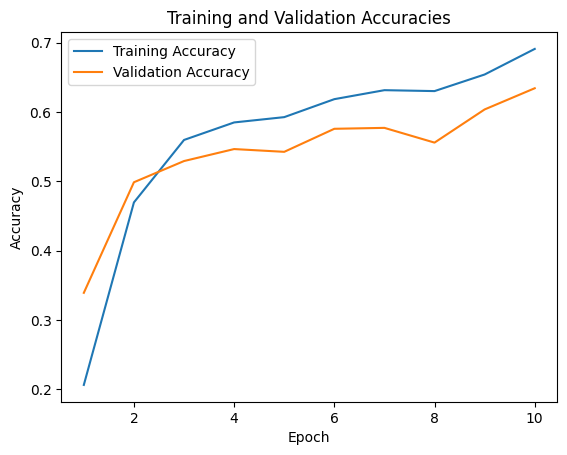

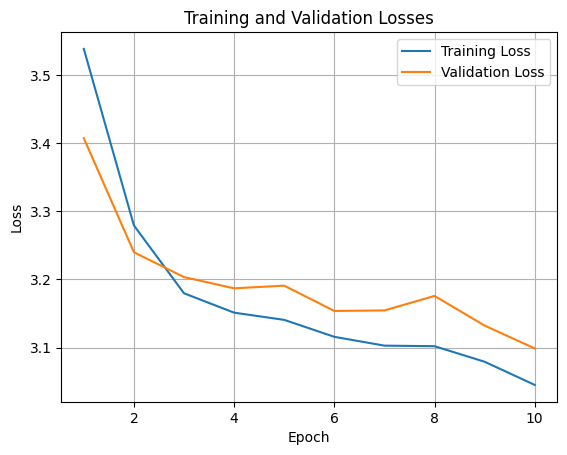

In [ ]:
trainModel(tuned_densenet161__model, 10)

In [ ]:
evalModel(tuned_densenet161__model, nn.CrossEntropyLoss())

Test Loss: 3.5094, Test Accuracy: 0.2308


#### DenseNet169

##### Load Model

In [ ]:
default_weight_densenet169 = models.DenseNet169_Weights.DEFAULT
densenet169_model = models.densenet169(weights=default_weight_densenet169)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:04<00:00, 13.7MB/s]


In [ ]:
for param in densenet169_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = densenet169_model.classifier.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_densenet169__model = densenet169_model

tuned_densenet169__model.classifier = new_head

In [ ]:
print(tuned_densenet169__model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

##### Training


Epoch [1/10], Train Loss: 3.5436, Train Accuracy: 0.2052, Val Loss: 3.3501, Val Accuracy: 0.4082
Epoch [2/10], Train Loss: 3.2630, Train Accuracy: 0.4832, Val Loss: 3.2440, Val Accuracy: 0.4854
Epoch [3/10], Train Loss: 3.1887, Train Accuracy: 0.5504, Val Loss: 3.1704, Val Accuracy: 0.5665
Epoch [4/10], Train Loss: 3.1465, Train Accuracy: 0.5903, Val Loss: 3.1554, Val Accuracy: 0.5838
Epoch [5/10], Train Loss: 3.1191, Train Accuracy: 0.6176, Val Loss: 3.1487, Val Accuracy: 0.5811
Epoch [6/10], Train Loss: 3.1097, Train Accuracy: 0.6245, Val Loss: 3.1382, Val Accuracy: 0.5984
Epoch [7/10], Train Loss: 3.0953, Train Accuracy: 0.6402, Val Loss: 3.1337, Val Accuracy: 0.5997
Epoch [8/10], Train Loss: 3.0833, Train Accuracy: 0.6501, Val Loss: 3.1197, Val Accuracy: 0.6117
Epoch [9/10], Train Loss: 3.0735, Train Accuracy: 0.6575, Val Loss: 3.1199, Val Accuracy: 0.6130
Epoch [10/10], Train Loss: 3.0682, Train Accuracy: 0.6644, Val Loss: 3.1118, Val Accuracy: 0.6237


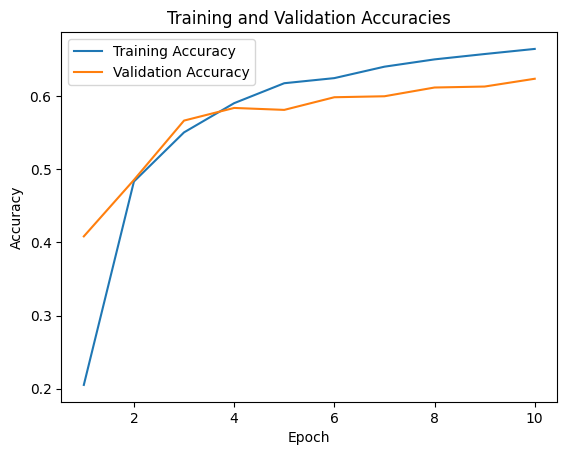

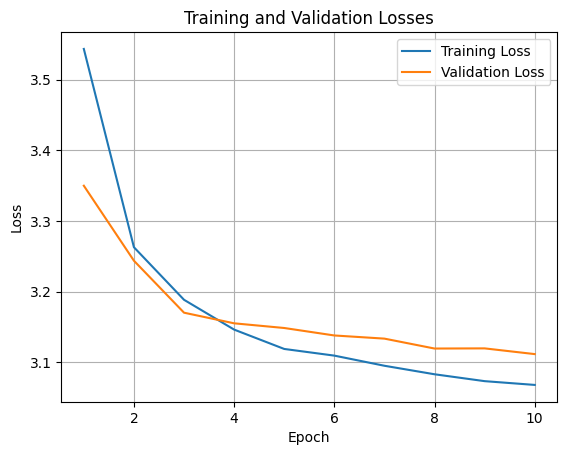

In [ ]:
trainModel(tuned_densenet169__model, 10)

In [ ]:
evalModel(tuned_densenet169__model, nn.CrossEntropyLoss())

Test Loss: 3.5389, Test Accuracy: 0.1888


#### DenseNet201

##### Load Model

In [ ]:
default_weight_denseNet201 = models.DenseNet201_Weights.DEFAULT
densenet201_model = models.densenet201(weights=default_weight_denseNet201)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:05<00:00, 13.6MB/s]


In [ ]:
for param in densenet201_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = densenet201_model.classifier.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_densenet201__model = densenet201_model

tuned_densenet201__model.classifier = new_head

In [ ]:
print(tuned_densenet201__model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

##### Training

Epoch [1/10], Train Loss: 3.5105, Train Accuracy: 0.2288, Val Loss: 3.2980, Val Accuracy: 0.4641
Epoch [2/10], Train Loss: 3.2459, Train Accuracy: 0.5058, Val Loss: 3.1983, Val Accuracy: 0.5559
Epoch [3/10], Train Loss: 3.1178, Train Accuracy: 0.6275, Val Loss: 3.0570, Val Accuracy: 0.6955
Epoch [4/10], Train Loss: 3.0461, Train Accuracy: 0.6980, Val Loss: 3.0527, Val Accuracy: 0.6888
Epoch [5/10], Train Loss: 3.0136, Train Accuracy: 0.7256, Val Loss: 3.0233, Val Accuracy: 0.7168
Epoch [6/10], Train Loss: 3.0111, Train Accuracy: 0.7243, Val Loss: 3.0132, Val Accuracy: 0.7194
Epoch [7/10], Train Loss: 2.9943, Train Accuracy: 0.7403, Val Loss: 3.0041, Val Accuracy: 0.7287
Epoch [8/10], Train Loss: 2.9942, Train Accuracy: 0.7406, Val Loss: 3.0034, Val Accuracy: 0.7314
Epoch [9/10], Train Loss: 2.9705, Train Accuracy: 0.7655, Val Loss: 3.0043, Val Accuracy: 0.7354
Epoch [10/10], Train Loss: 2.9593, Train Accuracy: 0.7765, Val Loss: 2.9851, Val Accuracy: 0.7460


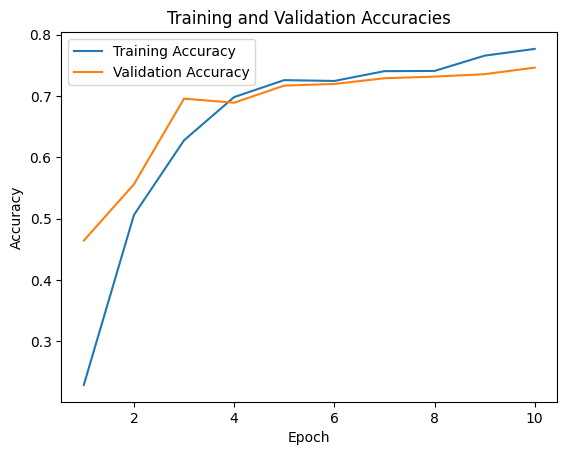

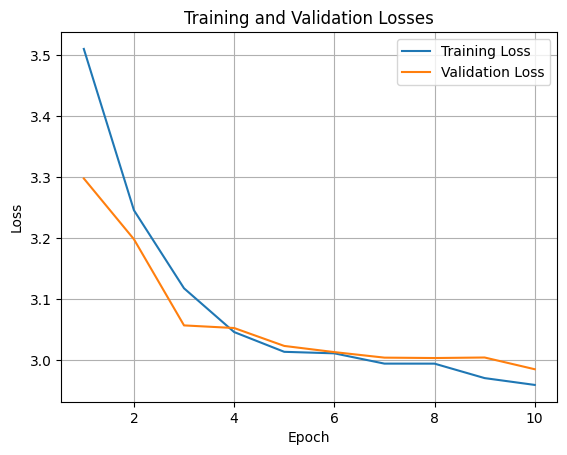

In [ ]:
trainModel(tuned_densenet201__model, 10)

In [ ]:
evalModel(tuned_densenet201__model, nn.CrossEntropyLoss())

Test Loss: 3.4506, Test Accuracy: 0.2727


## MaxVit

### Load Model

In [ ]:
default_weight_maxvit = models.MaxVit_T_Weights.DEFAULT
maxvit_model = models.maxvit_t(weights=default_weight_maxvit)

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://download.pytorch.org/models/maxvit_t-bc5ab103.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\maxvit_t-bc5ab103.pth
100%|██████████| 119M/119M [00:09<00:00, 13.8MB/s] 


In [ ]:
for param in maxvit_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = maxvit_model.classifier[5].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_maxvit_model = maxvit_model

tuned_maxvit_model.classifier[5] = new_head

In [ ]:
print(tuned_maxvit_model)

### Training

In [ ]:
trainModel(tuned_maxvit_model, 10)

In [ ]:
evalModel(tuned_maxvit_model, nn.CrossEntropyLoss())

## MNASNet

### Models

#### MNASNET0_5

##### Load Model

In [ ]:
default_weight_mnasnet0_5 = models.MNASNet0_5_Weights.DEFAULT
mnasnet0_5_model = models.mnasnet0_5(weights=default_weight_mnasnet0_5)

Downloading: "https://download.pytorch.org/models/mnasnet0.5_top1_67.823-3ffadce67e.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\mnasnet0.5_top1_67.823-3ffadce67e.pth
100%|██████████| 8.59M/8.59M [00:00<00:00, 13.8MB/s]


In [ ]:
for param in mnasnet0_5_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = mnasnet0_5_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_mnasnet0_5_model = mnasnet0_5_model

tuned_mnasnet0_5_model.classifier[1] = new_head

In [ ]:
print(tuned_mnasnet0_5_model)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(8, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(24, 24,

##### Training

In [ ]:
trainModel(tuned_mnasnet0_5_model, 10)

In [ ]:
evalModel(tuned_mnasnet0_5_model, nn.CrossEntropyLoss())

#### MNASNET0_75

##### Load Model

In [ ]:
default_weight_mnasnet0_75 = models.MNASNet0_75_Weights.DEFAULT
mnasnet0_75_model = models.mnasnet0_75(weights=default_weight_mnasnet0_75)

Downloading: "https://download.pytorch.org/models/mnasnet0_75-7090bc5f.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\mnasnet0_75-7090bc5f.pth
100%|██████████| 12.3M/12.3M [00:02<00:00, 6.13MB/s]


In [ ]:
for param in mnasnet0_75_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = mnasnet0_75_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_mnasnet0_75_model = mnasnet0_75_model

tuned_mnasnet0_75_model.classifier[1] = new_head

In [ ]:
print(tuned_mnasnet0_75_model)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 3.4909, Train Accuracy: 0.2710, Val Loss: 3.3321, Val Accuracy: 0.4481
Epoch [2/10], Train Loss: 3.2325, Train Accuracy: 0.5121, Val Loss: 3.2099, Val Accuracy: 0.5532
Epoch [3/10], Train Loss: 3.1453, Train Accuracy: 0.5963, Val Loss: 3.2002, Val Accuracy: 0.5399
Epoch [4/10], Train Loss: 3.1156, Train Accuracy: 0.6242, Val Loss: 3.1703, Val Accuracy: 0.5771
Epoch [5/10], Train Loss: 3.0923, Train Accuracy: 0.6418, Val Loss: 3.1641, Val Accuracy: 0.5705
Epoch [6/10], Train Loss: 3.0841, Train Accuracy: 0.6501, Val Loss: 3.1420, Val Accuracy: 0.5931
Epoch [7/10], Train Loss: 3.0640, Train Accuracy: 0.6714, Val Loss: 3.0979, Val Accuracy: 0.6410
Epoch [8/10], Train Loss: 3.0493, Train Accuracy: 0.6871, Val Loss: 3.0703, Val Accuracy: 0.6676
Epoch [9/10], Train Loss: 3.0329, Train Accuracy: 0.7000, Val Loss: 3.0721, Val Accuracy: 0.6662
Epoch [10/10], Train Loss: 3.0252, Train Accuracy: 0.7073, Val Loss: 3.0662, Val Accuracy: 0.6715


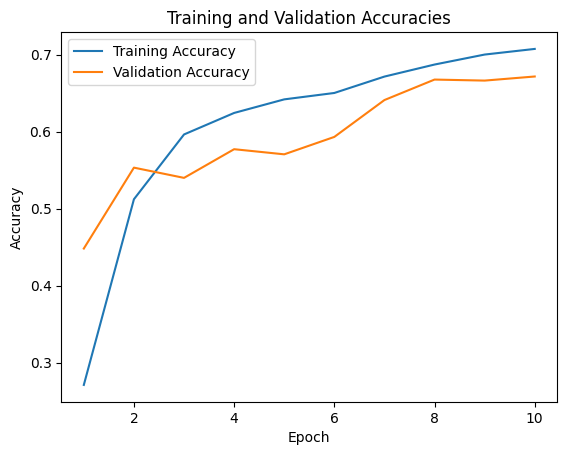

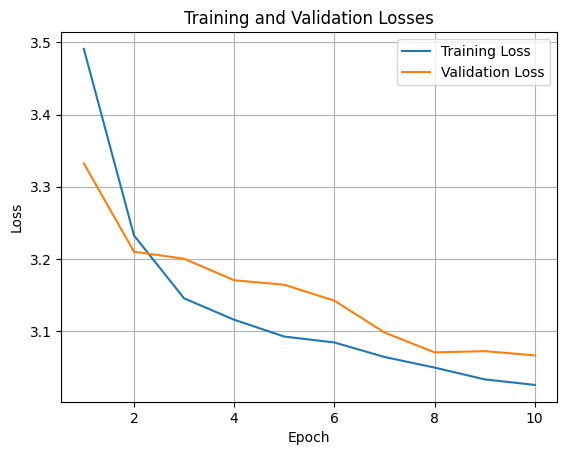

In [ ]:
trainModel(tuned_mnasnet0_75_model, 10)

In [ ]:
evalModel(tuned_mnasnet0_75_model, nn.CrossEntropyLoss())

Test Loss: 3.5520, Test Accuracy: 0.1818


#### MNASNET1_0

##### Load Model

In [ ]:
default_weight_mnasnet1_0 = models.MNASNet1_0_Weights.DEFAULT
mnasnet1_0_model = models.mnasnet1_0(weights=default_weight_mnasnet1_0)

Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\mnasnet1.0_top1_73.512-f206786ef8.pth
100%|██████████| 16.9M/16.9M [00:01<00:00, 13.8MB/s]


In [ ]:
for param in mnasnet1_0_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = mnasnet1_0_model.classifier.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_mnasnet1_0_model = mnasnet1_0_model

tuned_mnasnet1_0_model.classifier[1] = new_head

In [ ]:
print(tuned_mnasnet1_0_model)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

##### Training

Epoch [1/10], Train Loss: 3.5211, Train Accuracy: 0.2298, Val Loss: 3.3264, Val Accuracy: 0.4189
Epoch [2/10], Train Loss: 3.2607, Train Accuracy: 0.4892, Val Loss: 3.2131, Val Accuracy: 0.5266
Epoch [3/10], Train Loss: 3.1976, Train Accuracy: 0.5444, Val Loss: 3.1877, Val Accuracy: 0.5519
Epoch [4/10], Train Loss: 3.1652, Train Accuracy: 0.5707, Val Loss: 3.1692, Val Accuracy: 0.5691
Epoch [5/10], Train Loss: 3.1467, Train Accuracy: 0.5893, Val Loss: 3.1487, Val Accuracy: 0.5851
Epoch [6/10], Train Loss: 3.1200, Train Accuracy: 0.6199, Val Loss: 3.1294, Val Accuracy: 0.6090
Epoch [7/10], Train Loss: 3.0877, Train Accuracy: 0.6478, Val Loss: 3.1383, Val Accuracy: 0.6011
Epoch [8/10], Train Loss: 3.0810, Train Accuracy: 0.6525, Val Loss: 3.1135, Val Accuracy: 0.6237
Epoch [9/10], Train Loss: 3.0570, Train Accuracy: 0.6787, Val Loss: 3.0939, Val Accuracy: 0.6410
Epoch [10/10], Train Loss: 3.0378, Train Accuracy: 0.6990, Val Loss: 3.0543, Val Accuracy: 0.6795


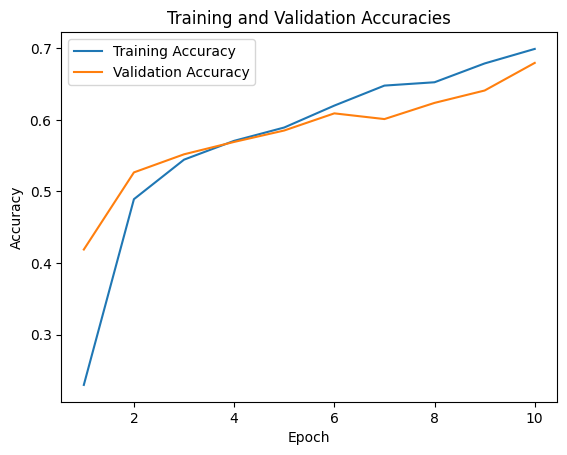

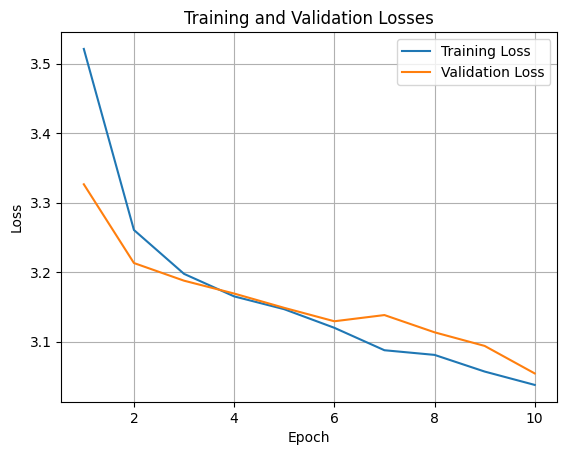

In [ ]:
trainModel(tuned_mnasnet1_0_model, 10)

In [ ]:
evalModel(tuned_mnasnet1_0_model, nn.CrossEntropyLoss())

Test Loss: 3.5479, Test Accuracy: 0.1818


#### MNASNET1_3

##### Load Model

In [ ]:
default_weight_mnasnet1_3 = models.MNASNet1_3_Weights.DEFAULT
mnasnet1_3_model = models.mnasnet1_3(weights=default_weight_mnasnet1_3)

Downloading: "https://download.pytorch.org/models/mnasnet1_3-a4c69d6f.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\mnasnet1_3-a4c69d6f.pth
100%|██████████| 24.2M/24.2M [00:03<00:00, 8.13MB/s]


In [ ]:
for param in mnasnet1_3_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = mnasnet1_3_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_mnasnet1_3_model = mnasnet1_3_model

tuned_mnasnet1_3_model.classifier[1] = new_head

In [ ]:
print(tuned_mnasnet1_3_model)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(72, 

##### Training

Epoch [1/10], Train Loss: 3.5407, Train Accuracy: 0.2032, Val Loss: 3.3871, Val Accuracy: 0.3910
Epoch [2/10], Train Loss: 3.2487, Train Accuracy: 0.5062, Val Loss: 3.1758, Val Accuracy: 0.5824
Epoch [3/10], Train Loss: 3.1416, Train Accuracy: 0.5959, Val Loss: 3.1363, Val Accuracy: 0.6064
Epoch [4/10], Train Loss: 3.1056, Train Accuracy: 0.6315, Val Loss: 3.1403, Val Accuracy: 0.6011
Epoch [5/10], Train Loss: 3.0924, Train Accuracy: 0.6432, Val Loss: 3.1347, Val Accuracy: 0.6051
Epoch [6/10], Train Loss: 3.0659, Train Accuracy: 0.6721, Val Loss: 3.0834, Val Accuracy: 0.6529
Epoch [7/10], Train Loss: 3.0356, Train Accuracy: 0.7034, Val Loss: 3.0555, Val Accuracy: 0.6875
Epoch [8/10], Train Loss: 3.0199, Train Accuracy: 0.7157, Val Loss: 3.0711, Val Accuracy: 0.6689
Epoch [9/10], Train Loss: 3.0105, Train Accuracy: 0.7223, Val Loss: 3.0399, Val Accuracy: 0.6981
Epoch [10/10], Train Loss: 3.0087, Train Accuracy: 0.7246, Val Loss: 3.0317, Val Accuracy: 0.7074


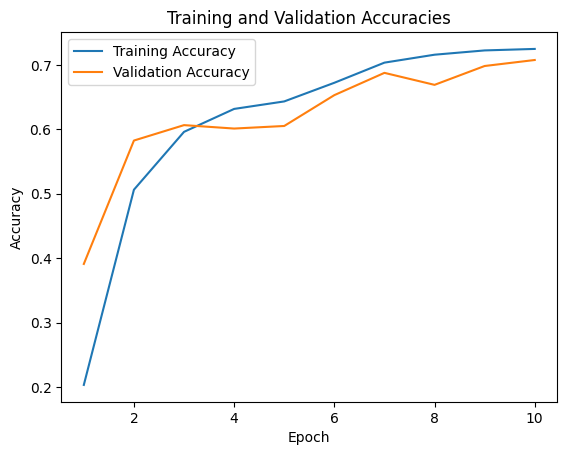

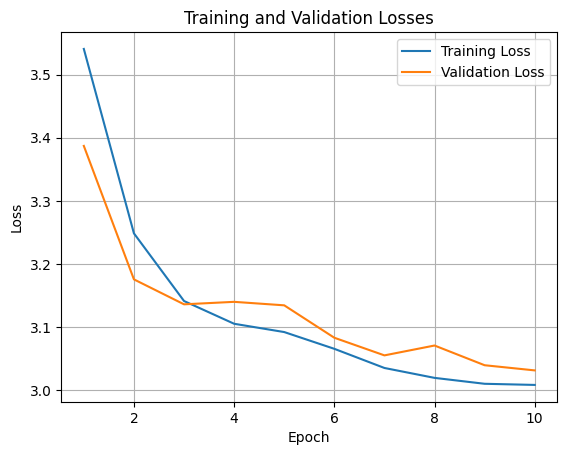

In [ ]:
trainModel(tuned_mnasnet1_3_model, 10)

In [ ]:
evalModel(tuned_mnasnet1_3_model, nn.CrossEntropyLoss())

Test Loss: 3.5093, Test Accuracy: 0.2168


## ShuffleNet V2

### Models

#### ShuffleNetV2_x0_5

##### Load Model

In [ ]:
default_weight_shuffleNetV2_x0_5 = models.ShuffleNet_V2_X0_5_Weights.DEFAULT
shufflenetv2_x0_5_model = models.shufflenet_v2_x0_5(weights=default_weight_shuffleNetV2_x0_5)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\shufflenetv2_x0.5-f707e7126e.pth
100%|██████████| 5.28M/5.28M [00:00<00:00, 13.8MB/s]


In [ ]:
for param in shufflenetv2_x0_5_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = shufflenetv2_x0_5_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_shufflenetv2_x0_5_model = shufflenetv2_x0_5_model

tuned_shufflenetv2_x0_5_model.fc = new_head

In [ ]:
print(tuned_shufflenetv2_x0_5_model)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

##### Training

Epoch [1/10], Train Loss: 3.6591, Train Accuracy: 0.0845, Val Loss: 3.5688, Val Accuracy: 0.1875
Epoch [2/10], Train Loss: 3.4790, Train Accuracy: 0.2843, Val Loss: 3.3842, Val Accuracy: 0.3856
Epoch [3/10], Train Loss: 3.3498, Train Accuracy: 0.4077, Val Loss: 3.3190, Val Accuracy: 0.4322
Epoch [4/10], Train Loss: 3.2938, Train Accuracy: 0.4559, Val Loss: 3.2940, Val Accuracy: 0.4481
Epoch [5/10], Train Loss: 3.2360, Train Accuracy: 0.5158, Val Loss: 3.2239, Val Accuracy: 0.5293
Epoch [6/10], Train Loss: 3.1968, Train Accuracy: 0.5497, Val Loss: 3.2175, Val Accuracy: 0.5319
Epoch [7/10], Train Loss: 3.1850, Train Accuracy: 0.5597, Val Loss: 3.1865, Val Accuracy: 0.5572
Epoch [8/10], Train Loss: 3.1528, Train Accuracy: 0.5906, Val Loss: 3.1769, Val Accuracy: 0.5691
Epoch [9/10], Train Loss: 3.1387, Train Accuracy: 0.6039, Val Loss: 3.1696, Val Accuracy: 0.5665
Epoch [10/10], Train Loss: 3.1317, Train Accuracy: 0.6116, Val Loss: 3.1736, Val Accuracy: 0.5612


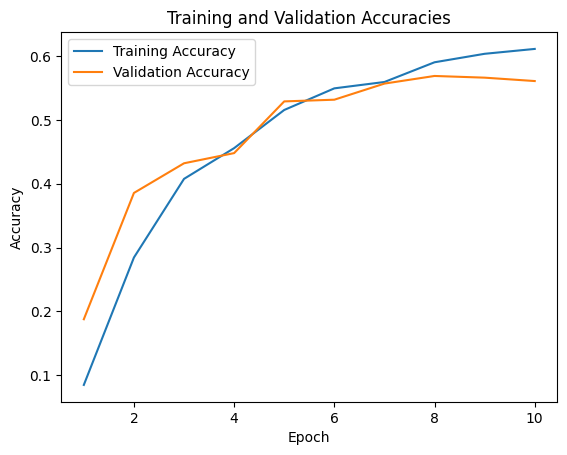

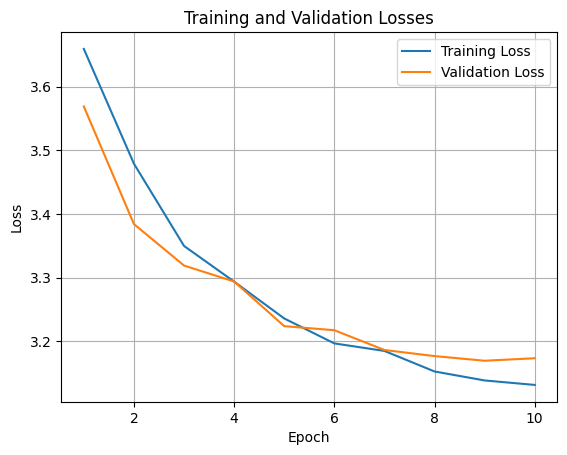

In [ ]:
trainModel(tuned_shufflenetv2_x0_5_model, 10)

In [ ]:
evalModel(tuned_shufflenetv2_x0_5_model, nn.CrossEntropyLoss())

Test Loss: 3.5856, Test Accuracy: 0.1538


#### ShuffleNetV2_x1_0

##### Load Model

In [ ]:
default_weight_shuffleNetV2_x1_0 = models.ShuffleNet_V2_X1_0_Weights.DEFAULT
shufflenetv2_x1_0_model = models.shufflenet_v2_x1_0(weights=default_weight_shuffleNetV2_x1_0)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:01<00:00, 4.82MB/s]


In [ ]:
for param in shufflenetv2_x1_0_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = shufflenetv2_x1_0_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_shufflenetv2_x1_0_model = shufflenetv2_x1_0_model

tuned_shufflenetv2_x1_0_model.fc = new_head

In [ ]:
print(tuned_shufflenetv2_x1_0_model)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

##### Training

Epoch [1/10], Train Loss: 3.6674, Train Accuracy: 0.0672, Val Loss: 3.5994, Val Accuracy: 0.1702
Epoch [2/10], Train Loss: 3.4777, Train Accuracy: 0.2986, Val Loss: 3.3803, Val Accuracy: 0.4096
Epoch [3/10], Train Loss: 3.2885, Train Accuracy: 0.4902, Val Loss: 3.2702, Val Accuracy: 0.4787
Epoch [4/10], Train Loss: 3.2073, Train Accuracy: 0.5517, Val Loss: 3.2146, Val Accuracy: 0.5439
Epoch [5/10], Train Loss: 3.1729, Train Accuracy: 0.5767, Val Loss: 3.1892, Val Accuracy: 0.5612
Epoch [6/10], Train Loss: 3.1444, Train Accuracy: 0.6003, Val Loss: 3.1828, Val Accuracy: 0.5638
Epoch [7/10], Train Loss: 3.1156, Train Accuracy: 0.6309, Val Loss: 3.1531, Val Accuracy: 0.5891
Epoch [8/10], Train Loss: 3.0869, Train Accuracy: 0.6585, Val Loss: 3.1212, Val Accuracy: 0.6237
Epoch [9/10], Train Loss: 3.0747, Train Accuracy: 0.6714, Val Loss: 3.1035, Val Accuracy: 0.6396
Epoch [10/10], Train Loss: 3.0523, Train Accuracy: 0.6891, Val Loss: 3.1075, Val Accuracy: 0.6330


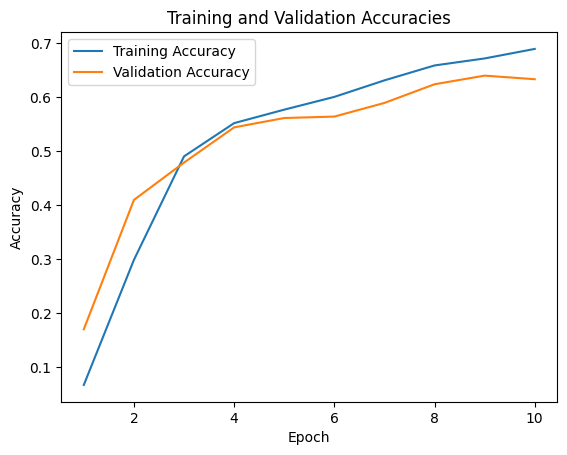

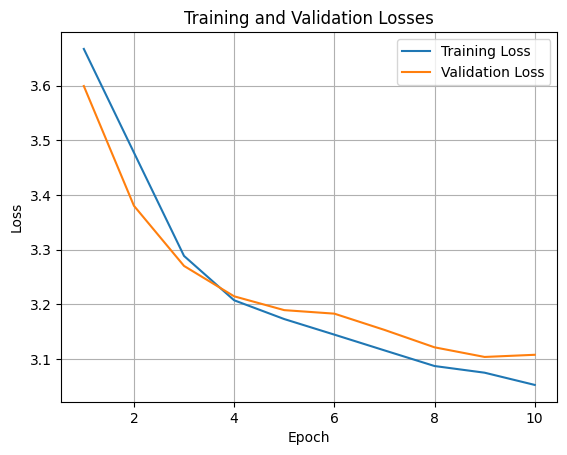

In [ ]:
trainModel(tuned_shufflenetv2_x1_0_model, 10)

In [ ]:
evalModel(tuned_shufflenetv2_x1_0_model, nn.CrossEntropyLoss())

Test Loss: 3.5687, Test Accuracy: 0.1678


#### ShuffleNetV2_x1_5

##### Load Model

In [ ]:
default_weight_shuffleNetV2_x1_5 = models.ShuffleNet_V2_X1_5_Weights.DEFAULT
shufflenetv2_x1_5_model = models.shufflenet_v2_x1_5(weights=default_weight_shuffleNetV2_x1_5)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1_5-3c479a10.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\shufflenetv2_x1_5-3c479a10.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 13.6MB/s]


In [ ]:
for param in shufflenetv2_x1_5_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = shufflenetv2_x1_5_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_shufflenetv2_x1_5_model = shufflenetv2_x1_5_model

tuned_shufflenetv2_x1_5_model.fc = new_head

##### Training

Epoch [1/10], Train Loss: 3.5100, Train Accuracy: 0.2434, Val Loss: 3.3042, Val Accuracy: 0.4628
Epoch [2/10], Train Loss: 3.2002, Train Accuracy: 0.5564, Val Loss: 3.1545, Val Accuracy: 0.5944
Epoch [3/10], Train Loss: 3.0866, Train Accuracy: 0.6568, Val Loss: 3.0658, Val Accuracy: 0.6809
Epoch [4/10], Train Loss: 3.0341, Train Accuracy: 0.7060, Val Loss: 3.0565, Val Accuracy: 0.6809
Epoch [5/10], Train Loss: 3.0177, Train Accuracy: 0.7190, Val Loss: 3.0596, Val Accuracy: 0.6795
Epoch [6/10], Train Loss: 3.0070, Train Accuracy: 0.7286, Val Loss: 3.0350, Val Accuracy: 0.7035
Epoch [7/10], Train Loss: 2.9956, Train Accuracy: 0.7409, Val Loss: 3.0335, Val Accuracy: 0.7061
Epoch [8/10], Train Loss: 2.9746, Train Accuracy: 0.7602, Val Loss: 3.0327, Val Accuracy: 0.7008
Epoch [9/10], Train Loss: 2.9712, Train Accuracy: 0.7622, Val Loss: 3.0201, Val Accuracy: 0.7154
Epoch [10/10], Train Loss: 2.9689, Train Accuracy: 0.7655, Val Loss: 3.0269, Val Accuracy: 0.7101


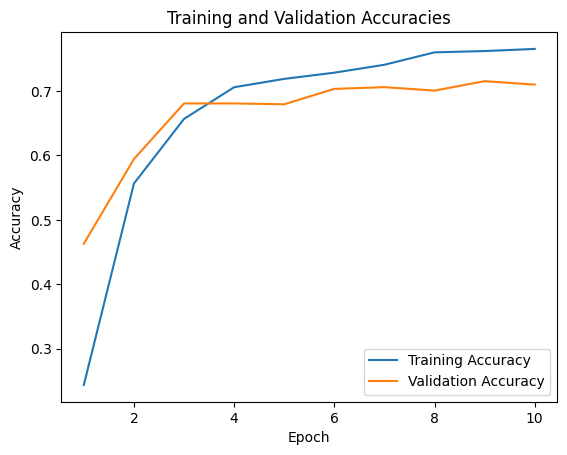

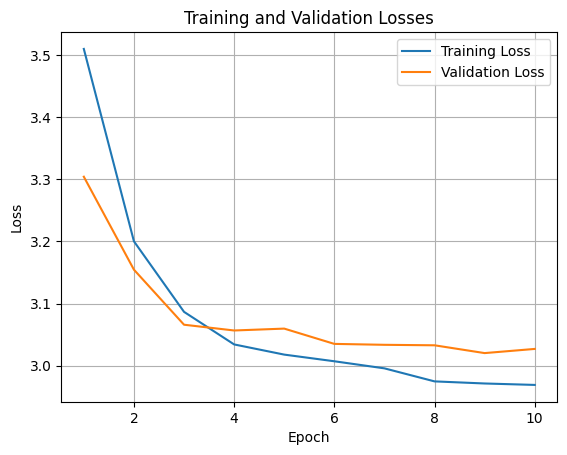

In [ ]:
trainModel(tuned_shufflenetv2_x1_5_model, 10)

In [ ]:
evalModel(tuned_shufflenetv2_x1_5_model, nn.CrossEntropyLoss())

Test Loss: 3.5716, Test Accuracy: 0.1469


#### ShuffleNetV2_x2_0

##### Load Model

In [ ]:
default_weight_shuffleNetV2_x2_0 = models.ShuffleNet_V2_X2_0_Weights.DEFAULT
shufflenetv2_x2_0_model = models.shufflenet_v2_x2_0(weights=default_weight_shuffleNetV2_x2_0)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x2_0-8be3c8ee.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\shufflenetv2_x2_0-8be3c8ee.pth
100%|██████████| 28.4M/28.4M [00:02<00:00, 12.4MB/s]


In [ ]:
for param in shufflenetv2_x2_0_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = shufflenetv2_x2_0_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_shufflenetv2_x2_0_model = shufflenetv2_x2_0_model

tuned_shufflenetv2_x2_0_model.fc = new_head

In [ ]:
print(tuned_shufflenetv2_x2_0_model)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

##### Training

Epoch [1/10], Train Loss: 3.4902, Train Accuracy: 0.2597, Val Loss: 3.2783, Val Accuracy: 0.5106
Epoch [2/10], Train Loss: 3.1605, Train Accuracy: 0.5890, Val Loss: 3.1173, Val Accuracy: 0.6210
Epoch [3/10], Train Loss: 3.0805, Train Accuracy: 0.6595, Val Loss: 3.0912, Val Accuracy: 0.6449
Epoch [4/10], Train Loss: 3.0499, Train Accuracy: 0.6864, Val Loss: 3.0718, Val Accuracy: 0.6649
Epoch [5/10], Train Loss: 3.0337, Train Accuracy: 0.7007, Val Loss: 3.0820, Val Accuracy: 0.6543
Epoch [6/10], Train Loss: 3.0108, Train Accuracy: 0.7226, Val Loss: 3.0446, Val Accuracy: 0.6981
Epoch [7/10], Train Loss: 2.9783, Train Accuracy: 0.7569, Val Loss: 3.0396, Val Accuracy: 0.6968
Epoch [8/10], Train Loss: 2.9775, Train Accuracy: 0.7552, Val Loss: 3.0408, Val Accuracy: 0.6955
Epoch [9/10], Train Loss: 2.9720, Train Accuracy: 0.7599, Val Loss: 3.0241, Val Accuracy: 0.7101
Epoch [10/10], Train Loss: 2.9645, Train Accuracy: 0.7689, Val Loss: 3.0178, Val Accuracy: 0.7181


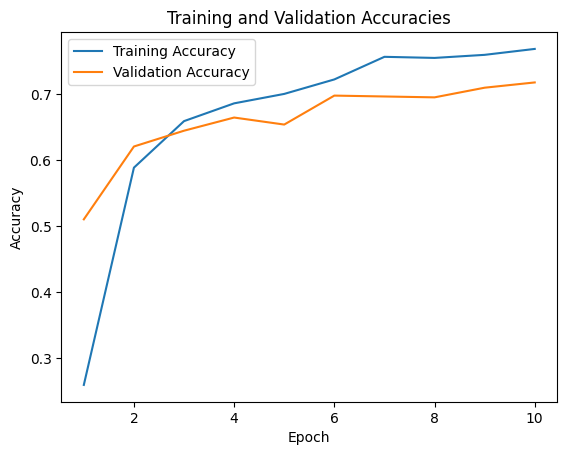

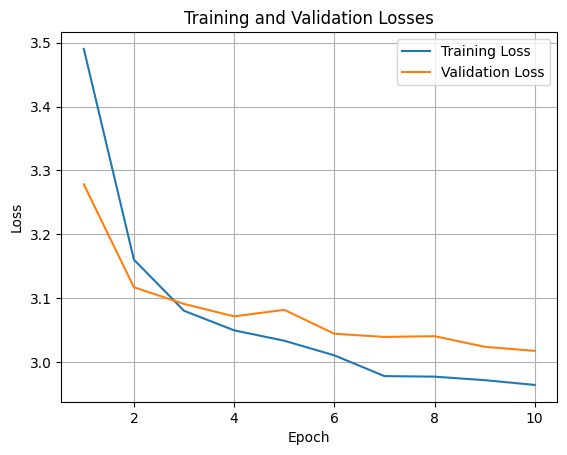

In [ ]:
trainModel(tuned_shufflenetv2_x2_0_model, 10)

In [ ]:
evalModel(tuned_shufflenetv2_x2_0_model, nn.CrossEntropyLoss())

Test Loss: 3.5017, Test Accuracy: 0.2308


## SqueezeNet

### Models

#### squeezenet1_0

##### Load Model

In [ ]:
default_weight_squeezenet1_0 = models.SqueezeNet1_0_Weights.DEFAULT
squeezenet1_0_model = models.squeezenet1_0(weights=default_weight_squeezenet1_0)

In [ ]:
for param in squeezenet1_0_model.parameters():
    param.requires_grad = False

In [ ]:
tuned_squeezenet1_0_model = squeezenet1_0_model

new_head = nn.Sequential(
    nn.Dropout(p=0.2),  # Dropout layer with 0.2 probability
    nn.Conv2d(512, 40, kernel_size=(1, 1), stride=(1, 1)),  # Convolutional layer with 40 filters
    nn.ReLU(inplace=True),  # ReLU activation
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),  # Adaptive average pooling layer
    nn.Flatten(),  # Flatten layer
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_squeezenet1_0_model.classifier = new_head

In [ ]:
print(tuned_squeezenet1_0_model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 3.5399, Train Accuracy: 0.1965, Val Loss: 3.3562, Val Accuracy: 0.3896
Epoch [2/10], Train Loss: 3.3491, Train Accuracy: 0.3888, Val Loss: 3.3428, Val Accuracy: 0.3936
Epoch [3/10], Train Loss: 3.3311, Train Accuracy: 0.3994, Val Loss: 3.3580, Val Accuracy: 0.3723
Epoch [4/10], Train Loss: 3.3018, Train Accuracy: 0.4297, Val Loss: 3.2903, Val Accuracy: 0.4455
Epoch [5/10], Train Loss: 3.2811, Train Accuracy: 0.4516, Val Loss: 3.2946, Val Accuracy: 0.4348
Epoch [6/10], Train Loss: 3.2567, Train Accuracy: 0.4752, Val Loss: 3.2668, Val Accuracy: 0.4694
Epoch [7/10], Train Loss: 3.2510, Train Accuracy: 0.4802, Val Loss: 3.2673, Val Accuracy: 0.4668
Epoch [8/10], Train Loss: 3.2153, Train Accuracy: 0.5171, Val Loss: 3.2602, Val Accuracy: 0.4734
Epoch [9/10], Train Loss: 3.2061, Train Accuracy: 0.5254, Val Loss: 3.2487, Val Accuracy: 0.4840
Epoch [10/10], Train Loss: 3.1981, Train Accuracy: 0.5338, Val Loss: 3.2350, Val Accuracy: 0.4934


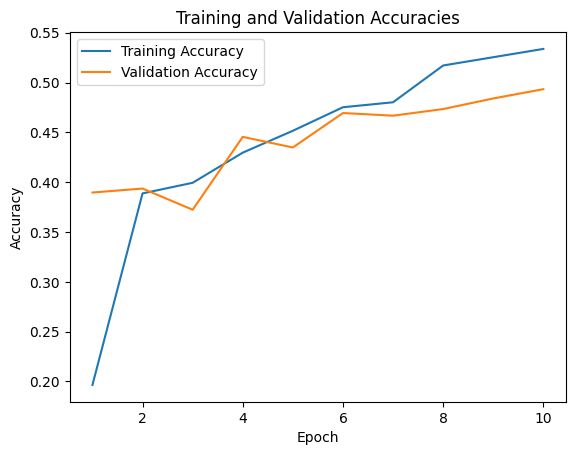

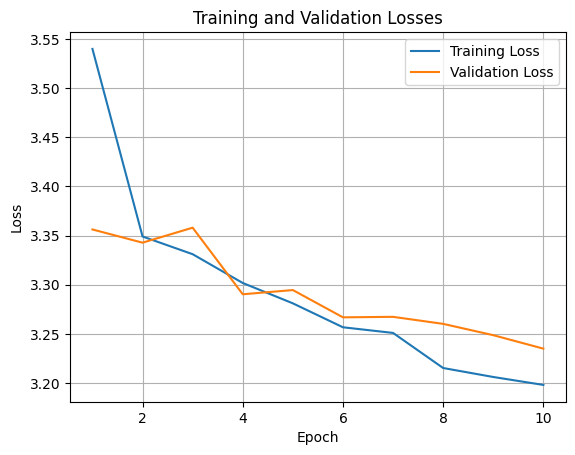

In [ ]:
trainModel(tuned_squeezenet1_0_model, 10)

In [ ]:
evalModel(tuned_squeezenet1_0_model, nn.CrossEntropyLoss())

Test Loss: 3.6105, Test Accuracy: 0.1189


#### squeezenet1_1

##### Load Model

In [ ]:
default_weight_squeezenet1_1 = models.SqueezeNet1_1_Weights.DEFAULT
squeezenet1_1_model = models.squeezenet1_1(weights=default_weight_squeezenet1_1)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 13.9MB/s]


In [ ]:
for param in squeezenet1_1_model.parameters():
    param.requires_grad = False

In [ ]:



tuned_squeezenet1_1_model = squeezenet1_1_model

new_head = nn.Sequential(
    nn.Dropout(p=0.2),  # Dropout layer with 0.2 probability
    nn.Conv2d(512, 40, kernel_size=(1, 1), stride=(1, 1)),  # Convolutional layer with 40 filters
    nn.ReLU(inplace=True),  # ReLU activation
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),  # Adaptive average pooling layer
    nn.Flatten(),  # Flatten layers
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_squeezenet1_1_model.classifier = new_head


In [ ]:
print(tuned_squeezenet1_1_model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 3.4257, Train Accuracy: 0.3552, Val Loss: 3.2078, Val Accuracy: 0.5638
Epoch [2/10], Train Loss: 3.1581, Train Accuracy: 0.6016, Val Loss: 3.1517, Val Accuracy: 0.6011
Epoch [3/10], Train Loss: 3.0922, Train Accuracy: 0.6601, Val Loss: 3.0792, Val Accuracy: 0.6755
Epoch [4/10], Train Loss: 3.0415, Train Accuracy: 0.7070, Val Loss: 3.0513, Val Accuracy: 0.7074
Epoch [5/10], Train Loss: 3.0078, Train Accuracy: 0.7383, Val Loss: 3.0076, Val Accuracy: 0.7420
Epoch [6/10], Train Loss: 2.9807, Train Accuracy: 0.7609, Val Loss: 3.0069, Val Accuracy: 0.7420
Epoch [7/10], Train Loss: 2.9719, Train Accuracy: 0.7669, Val Loss: 2.9962, Val Accuracy: 0.7540
Epoch [8/10], Train Loss: 2.9654, Train Accuracy: 0.7705, Val Loss: 2.9945, Val Accuracy: 0.7566
Epoch [9/10], Train Loss: 2.9629, Train Accuracy: 0.7735, Val Loss: 2.9946, Val Accuracy: 0.7593
Epoch [10/10], Train Loss: 2.9586, Train Accuracy: 0.7772, Val Loss: 3.0003, Val Accuracy: 0.7487


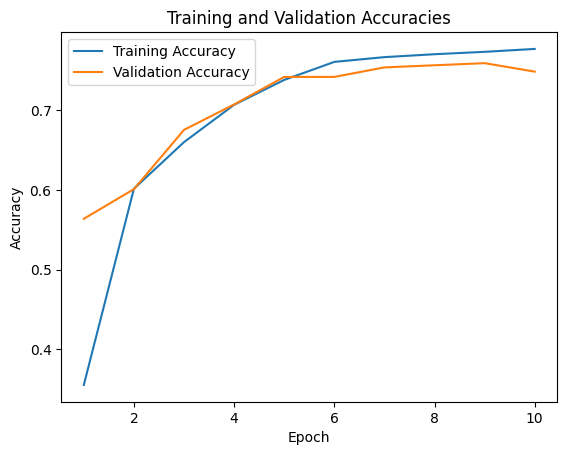

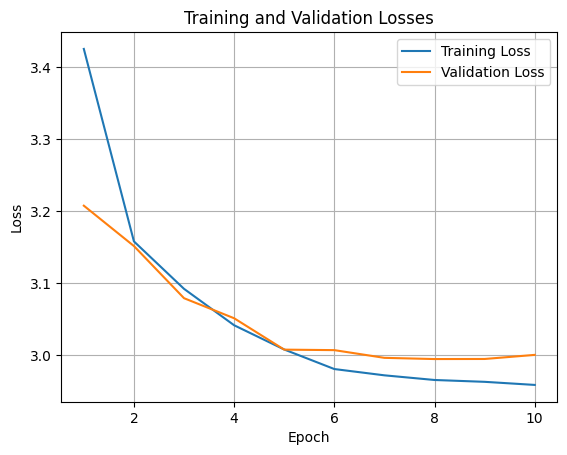

In [ ]:
trainModel(tuned_squeezenet1_1_model, 10)

In [ ]:
evalModel(tuned_squeezenet1_1_model, nn.CrossEntropyLoss())

Test Loss: 3.5428, Test Accuracy: 0.1888


## SwinTransformer

### Models

#### Swin_V2_t

##### Load Model

In [ ]:
default_weight_swin_v2_t = models.Swin_V2_T_Weights.DEFAULT
swin_v2_t_model = models.swin_v2_t(weights=default_weight_swin_v2_t)

In [ ]:
for param in swin_v2_t_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = swin_v2_t_model.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_swin_v2_t_model = swin_v2_t_model

tuned_swin_v2_t_model.head = new_head

In [ ]:
print(tuned_swin_v2_t_model)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 3.3343, Train Accuracy: 0.4659, Val Loss: 3.1292, Val Accuracy: 0.6170
Epoch [2/10], Train Loss: 3.0716, Train Accuracy: 0.6664, Val Loss: 3.0811, Val Accuracy: 0.6569
Epoch [3/10], Train Loss: 3.0482, Train Accuracy: 0.6864, Val Loss: 3.0387, Val Accuracy: 0.7021
Epoch [4/10], Train Loss: 3.0000, Train Accuracy: 0.7376, Val Loss: 3.0361, Val Accuracy: 0.7008
Epoch [5/10], Train Loss: 2.9818, Train Accuracy: 0.7539, Val Loss: 2.9786, Val Accuracy: 0.7673
Epoch [6/10], Train Loss: 2.9315, Train Accuracy: 0.8038, Val Loss: 2.9601, Val Accuracy: 0.7766
Epoch [7/10], Train Loss: 2.9017, Train Accuracy: 0.8344, Val Loss: 2.9255, Val Accuracy: 0.8059
Epoch [8/10], Train Loss: 2.8884, Train Accuracy: 0.8450, Val Loss: 2.9198, Val Accuracy: 0.8112
Epoch [9/10], Train Loss: 2.8794, Train Accuracy: 0.8537, Val Loss: 2.9282, Val Accuracy: 0.8045
Epoch [10/10], Train Loss: 2.8792, Train Accuracy: 0.8537, Val Loss: 2.9204, Val Accuracy: 0.8205


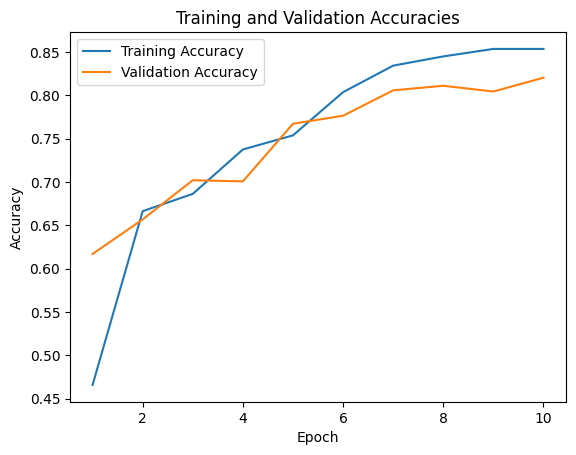

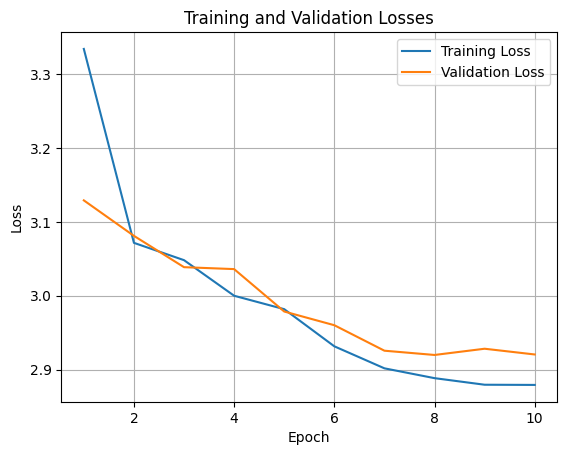

In [ ]:
trainModel(tuned_swin_v2_t_model, 10)

In [ ]:
evalModel(tuned_swin_v2_t_model, nn.CrossEntropyLoss())

Test Loss: 3.4682, Test Accuracy: 0.2727


#### Swin_V2_s

##### Load Model

In [ ]:
default_weight_swin_v2_s = models.Swin_V2_S_Weights.DEFAULT
swin_v2_s_model = models.swin_v2_s(weights=default_weight_swin_v2_s)

Downloading: "https://download.pytorch.org/models/swin_v2_s-637d8ceb.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\swin_v2_s-637d8ceb.pth
100%|██████████| 191M/191M [00:15<00:00, 12.6MB/s] 


In [ ]:
for param in swin_v2_s_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = swin_v2_s_model.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_swin_v2_s_model = swin_v2_s_model

tuned_swin_v2_s_model.head = new_head

In [ ]:
print(tuned_swin_v2_s_model)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 3.3419, Train Accuracy: 0.4506, Val Loss: 3.1336, Val Accuracy: 0.6024
Epoch [2/10], Train Loss: 3.0844, Train Accuracy: 0.6548, Val Loss: 3.0682, Val Accuracy: 0.6649
Epoch [3/10], Train Loss: 3.0397, Train Accuracy: 0.6964, Val Loss: 3.0456, Val Accuracy: 0.6862
Epoch [4/10], Train Loss: 3.0127, Train Accuracy: 0.7216, Val Loss: 3.0227, Val Accuracy: 0.7114
Epoch [5/10], Train Loss: 2.9967, Train Accuracy: 0.7373, Val Loss: 3.0213, Val Accuracy: 0.7114
Epoch [6/10], Train Loss: 2.9976, Train Accuracy: 0.7376, Val Loss: 3.0229, Val Accuracy: 0.7114
Epoch [7/10], Train Loss: 2.9985, Train Accuracy: 0.7346, Val Loss: 3.0028, Val Accuracy: 0.7287
Epoch [8/10], Train Loss: 2.9888, Train Accuracy: 0.7436, Val Loss: 3.0077, Val Accuracy: 0.7221
Epoch [9/10], Train Loss: 2.9723, Train Accuracy: 0.7606, Val Loss: 2.9774, Val Accuracy: 0.7527
Epoch [10/10], Train Loss: 2.9755, Train Accuracy: 0.7572, Val Loss: 2.9778, Val Accuracy: 0.7527


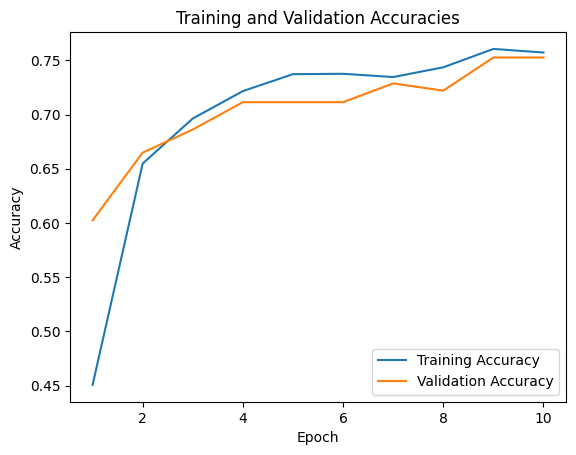

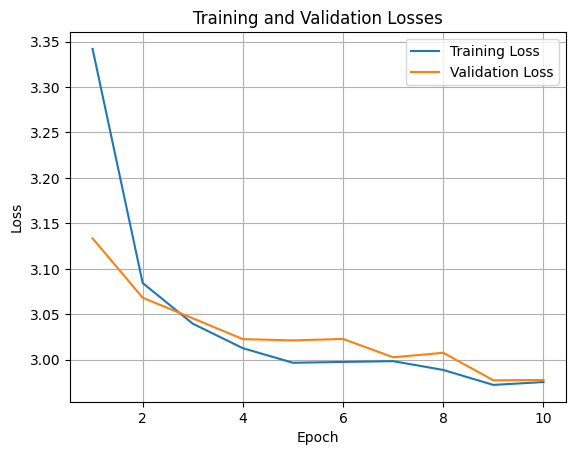

In [ ]:
trainModel(tuned_swin_v2_s_model, 10)

In [ ]:
evalModel(tuned_swin_v2_s_model, nn.CrossEntropyLoss())

Test Loss: 3.4648, Test Accuracy: 0.2797


#### Swin_V2_b

##### Load Model

In [ ]:
default_weight_swin_v2_b = models.Swin_V2_B_Weights.DEFAULT
swin_v2_b_model = models.swin_v2_b(weights=default_weight_swin_v2_b)

Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\swin_v2_b-781e5279.pth
100%|██████████| 336M/336M [00:26<00:00, 13.5MB/s] 


In [ ]:
for param in swin_v2_b_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = swin_v2_b_model.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_swin_v2_b_model = swin_v2_b_model

tuned_swin_v2_b_model.head = new_head

In [ ]:
print(tuned_swin_v2_b_model)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 3.3982, Train Accuracy: 0.3851, Val Loss: 3.2015, Val Accuracy: 0.5412
Epoch [2/10], Train Loss: 3.1359, Train Accuracy: 0.6046, Val Loss: 3.1214, Val Accuracy: 0.6223
Epoch [3/10], Train Loss: 3.0922, Train Accuracy: 0.6438, Val Loss: 3.1325, Val Accuracy: 0.6024
Epoch [4/10], Train Loss: 3.0694, Train Accuracy: 0.6651, Val Loss: 3.0897, Val Accuracy: 0.6449
Epoch [5/10], Train Loss: 3.0548, Train Accuracy: 0.6794, Val Loss: 3.0682, Val Accuracy: 0.6649
Epoch [6/10], Train Loss: 3.0279, Train Accuracy: 0.7050, Val Loss: 3.0495, Val Accuracy: 0.6848
Epoch [7/10], Train Loss: 3.0156, Train Accuracy: 0.7183, Val Loss: 3.0381, Val Accuracy: 0.6995
Epoch [8/10], Train Loss: 3.0011, Train Accuracy: 0.7313, Val Loss: 3.0329, Val Accuracy: 0.6981
Epoch [9/10], Train Loss: 2.9989, Train Accuracy: 0.7340, Val Loss: 3.0302, Val Accuracy: 0.6995
Epoch [10/10], Train Loss: 2.9938, Train Accuracy: 0.7386, Val Loss: 3.0298, Val Accuracy: 0.7021


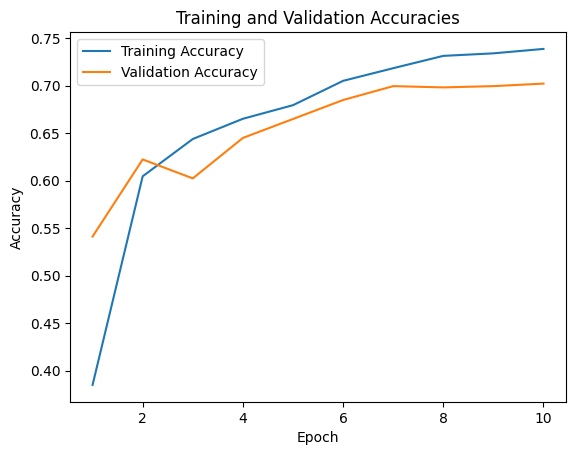

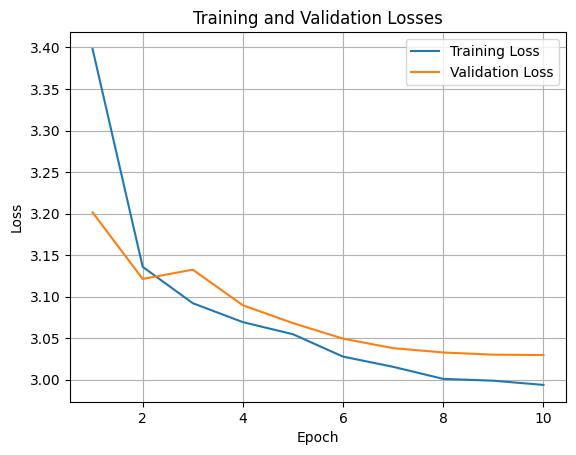

In [ ]:
trainModel(tuned_swin_v2_b_model, 10)

In [ ]:
evalModel(tuned_swin_v2_b_model, nn.CrossEntropyLoss())

Test Loss: 3.4422, Test Accuracy: 0.2867


## VGG

### Models

#### VGG11

##### Load Model

In [ ]:
default_weight_vgg11 = models.VGG11_Weights.DEFAULT
vgg11_model = models.vgg11(weights=default_weight_vgg11)

In [ ]:
for param in vgg11_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg11_model.classifier[6].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg11_model = vgg11_model

tuned_vgg11_model.classifier[6] = new_head

In [ ]:
print(tuned_vgg11_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

##### Training

Epoch [1/10], Train Loss: 3.3913, Train Accuracy: 0.3562, Val Loss: 3.2126, Val Accuracy: 0.5346
Epoch [2/10], Train Loss: 3.1915, Train Accuracy: 0.5454, Val Loss: 3.1423, Val Accuracy: 0.5878
Epoch [3/10], Train Loss: 3.1537, Train Accuracy: 0.5833, Val Loss: 3.1305, Val Accuracy: 0.6051
Epoch [4/10], Train Loss: 3.1250, Train Accuracy: 0.6099, Val Loss: 3.1035, Val Accuracy: 0.6330
Epoch [5/10], Train Loss: 3.1024, Train Accuracy: 0.6289, Val Loss: 3.0865, Val Accuracy: 0.6503
Epoch [6/10], Train Loss: 3.0871, Train Accuracy: 0.6452, Val Loss: 3.0735, Val Accuracy: 0.6609
Epoch [7/10], Train Loss: 3.0655, Train Accuracy: 0.6681, Val Loss: 3.0769, Val Accuracy: 0.6556
Epoch [8/10], Train Loss: 3.0595, Train Accuracy: 0.6718, Val Loss: 3.0598, Val Accuracy: 0.6729
Epoch [9/10], Train Loss: 3.0627, Train Accuracy: 0.6704, Val Loss: 3.0730, Val Accuracy: 0.6569
Epoch [10/10], Train Loss: 3.0480, Train Accuracy: 0.6844, Val Loss: 3.0494, Val Accuracy: 0.6835


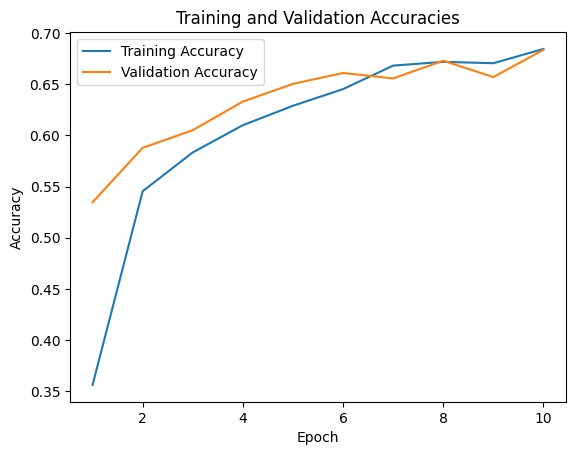

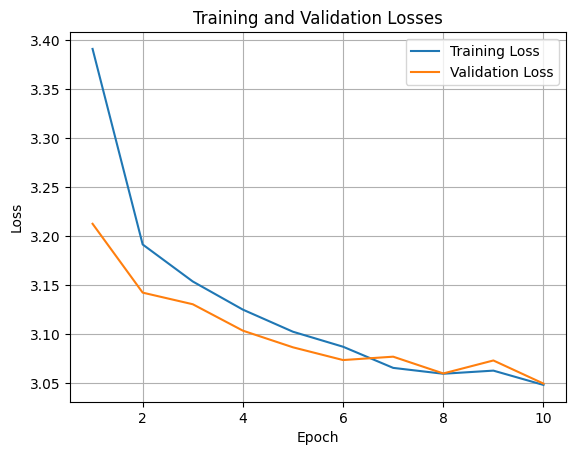

In [ ]:
trainModel(tuned_vgg11_model, 10)

In [ ]:
evalModel(tuned_vgg11_model, nn.CrossEntropyLoss())

Test Loss: 3.5242, Test Accuracy: 0.1888


#### VGG11_bn

##### Load Model

In [ ]:
default_weight_vgg11_bn = models.VGG11_BN_Weights.DEFAULT
vgg11_bn_model = models.vgg11_bn(weights=default_weight_vgg11_bn)

In [ ]:
for param in vgg11_bn_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg11_bn_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg11_bn_model = vgg11_bn_model

tuned_vgg11_bn_model.classifier = new_head

In [ ]:
print(tuned_vgg11_bn_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

##### Training

Epoch [1/10], Train Loss: 3.4179, Train Accuracy: 0.3289, Val Loss: 3.2391, Val Accuracy: 0.5027
Epoch [2/10], Train Loss: 3.1857, Train Accuracy: 0.5504, Val Loss: 3.2122, Val Accuracy: 0.5226
Epoch [3/10], Train Loss: 3.1321, Train Accuracy: 0.6019, Val Loss: 3.1559, Val Accuracy: 0.5771
Epoch [4/10], Train Loss: 3.0852, Train Accuracy: 0.6472, Val Loss: 3.1353, Val Accuracy: 0.6024
Epoch [5/10], Train Loss: 3.0597, Train Accuracy: 0.6721, Val Loss: 3.1400, Val Accuracy: 0.5931
Epoch [6/10], Train Loss: 3.0517, Train Accuracy: 0.6794, Val Loss: 3.1085, Val Accuracy: 0.6250
Epoch [7/10], Train Loss: 3.0387, Train Accuracy: 0.6921, Val Loss: 3.1045, Val Accuracy: 0.6303
Epoch [8/10], Train Loss: 3.0380, Train Accuracy: 0.6930, Val Loss: 3.1161, Val Accuracy: 0.6170
Epoch [9/10], Train Loss: 3.0323, Train Accuracy: 0.6977, Val Loss: 3.0975, Val Accuracy: 0.6343
Epoch [10/10], Train Loss: 3.0330, Train Accuracy: 0.6977, Val Loss: 3.1451, Val Accuracy: 0.5864


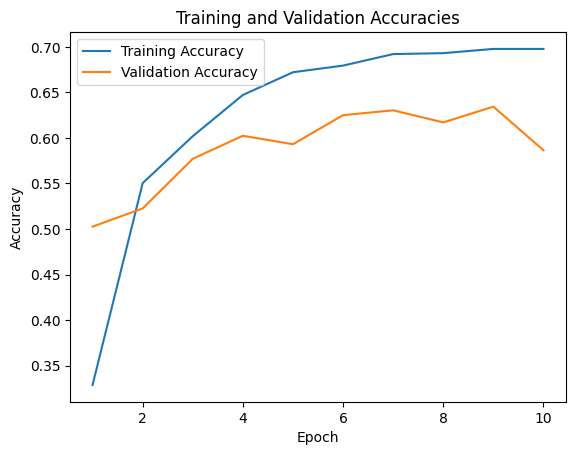

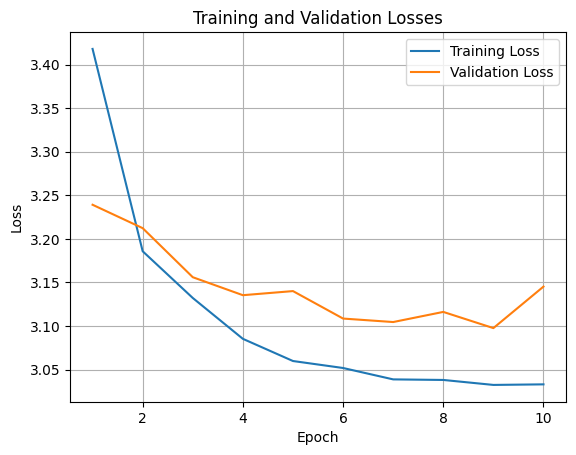

In [ ]:
trainModel(tuned_vgg11_bn_model, 10)

In [ ]:
evalModel(tuned_vgg11_bn_model, nn.CrossEntropyLoss())

Test Loss: 3.6068, Test Accuracy: 0.1189


#### VGG13

##### Load Model

In [ ]:
default_weight_vgg13 = models.VGG13_Weights.DEFAULT
vgg13_model = models.vgg13(weights=default_weight_vgg13)

In [ ]:
for param in vgg13_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg13_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg13_model = vgg13_model

tuned_vgg13_model.classifier = new_head

In [ ]:
print(tuned_vgg13_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

##### Training

Epoch [1/10], Train Loss: 3.3966, Train Accuracy: 0.3382, Val Loss: 3.3111, Val Accuracy: 0.4215
Epoch [2/10], Train Loss: 3.2625, Train Accuracy: 0.4679, Val Loss: 3.2847, Val Accuracy: 0.4508
Epoch [3/10], Train Loss: 3.2316, Train Accuracy: 0.4988, Val Loss: 3.2376, Val Accuracy: 0.4960
Epoch [4/10], Train Loss: 3.1912, Train Accuracy: 0.5391, Val Loss: 3.2352, Val Accuracy: 0.4947
Epoch [5/10], Train Loss: 3.1920, Train Accuracy: 0.5384, Val Loss: 3.2666, Val Accuracy: 0.4641
Epoch [6/10], Train Loss: 3.1854, Train Accuracy: 0.5451, Val Loss: 3.2356, Val Accuracy: 0.4960
Epoch [7/10], Train Loss: 3.1771, Train Accuracy: 0.5534, Val Loss: 3.2357, Val Accuracy: 0.4960
Epoch [8/10], Train Loss: 3.1554, Train Accuracy: 0.5753, Val Loss: 3.1717, Val Accuracy: 0.5585
Epoch [9/10], Train Loss: 3.1607, Train Accuracy: 0.5707, Val Loss: 3.1982, Val Accuracy: 0.5346
Epoch [10/10], Train Loss: 3.1610, Train Accuracy: 0.5697, Val Loss: 3.2344, Val Accuracy: 0.4947


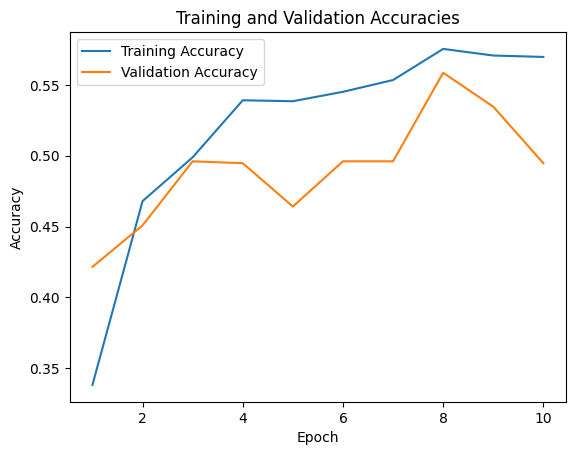

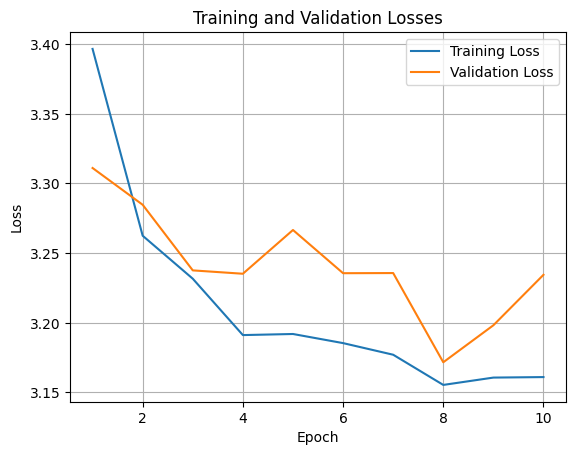

In [ ]:
trainModel(tuned_vgg13_model, 10)

In [ ]:
evalModel(tuned_vgg13_model, nn.CrossEntropyLoss())

Test Loss: 3.5959, Test Accuracy: 0.1329


#### VGG13_bn

##### Load Model

In [ ]:
default_weight_vgg13_bn = models.VGG13_BN_Weights.DEFAULT
vgg13_bn_model = models.vgg13_bn(weights=default_weight_vgg13_bn)

In [ ]:
for param in vgg13_bn_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg13_bn_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg13_bn_model = vgg13_bn_model

tuned_vgg13_bn_model.classifier = new_head

In [ ]:
print(tuned_vgg13_bn_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

##### Training

Epoch [1/10], Train Loss: 3.5129, Train Accuracy: 0.2182, Val Loss: 3.4094, Val Accuracy: 0.3324
Epoch [2/10], Train Loss: 3.3069, Train Accuracy: 0.4273, Val Loss: 3.3053, Val Accuracy: 0.4282
Epoch [3/10], Train Loss: 3.2394, Train Accuracy: 0.4932, Val Loss: 3.2631, Val Accuracy: 0.4734
Epoch [4/10], Train Loss: 3.1998, Train Accuracy: 0.5304, Val Loss: 3.2583, Val Accuracy: 0.4761
Epoch [5/10], Train Loss: 3.1699, Train Accuracy: 0.5617, Val Loss: 3.2329, Val Accuracy: 0.5013
Epoch [6/10], Train Loss: 3.1448, Train Accuracy: 0.5856, Val Loss: 3.1979, Val Accuracy: 0.5372
Epoch [7/10], Train Loss: 3.1272, Train Accuracy: 0.6029, Val Loss: 3.2029, Val Accuracy: 0.5319
Epoch [8/10], Train Loss: 3.0889, Train Accuracy: 0.6452, Val Loss: 3.1706, Val Accuracy: 0.5652
Epoch [9/10], Train Loss: 3.0629, Train Accuracy: 0.6684, Val Loss: 3.1153, Val Accuracy: 0.6197
Epoch [10/10], Train Loss: 3.0392, Train Accuracy: 0.6924, Val Loss: 3.1323, Val Accuracy: 0.5957


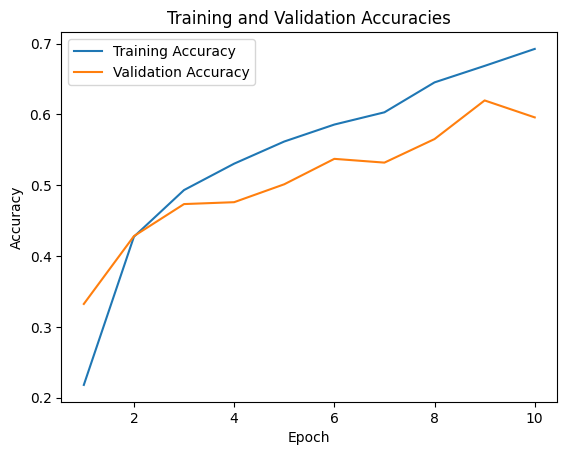

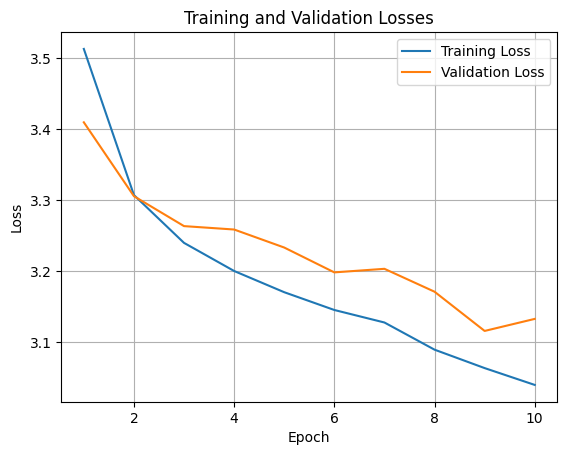

In [ ]:
trainModel(tuned_vgg13_bn_model, 10)

In [ ]:
evalModel(tuned_vgg13_bn_model, nn.CrossEntropyLoss())

Test Loss: 3.5225, Test Accuracy: 0.2168


#### VGG16

##### Load Model

In [ ]:
default_weight_vgg16 = models.VGG16_Weights.DEFAULT
vgg16_model = models.vgg16(weights=default_weight_vgg16)

In [ ]:
for param in vgg16_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg16_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg16_model = vgg16_model

tuned_vgg16_model.classifier = new_head

In [ ]:
print(tuned_vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

##### Training

Epoch [1/10], Train Loss: 3.4584, Train Accuracy: 0.2740, Val Loss: 3.3639, Val Accuracy: 0.3657
Epoch [2/10], Train Loss: 3.3184, Train Accuracy: 0.4110, Val Loss: 3.3364, Val Accuracy: 0.3976
Epoch [3/10], Train Loss: 3.2738, Train Accuracy: 0.4583, Val Loss: 3.3280, Val Accuracy: 0.4016
Epoch [4/10], Train Loss: 3.2567, Train Accuracy: 0.4722, Val Loss: 3.3303, Val Accuracy: 0.3976
Epoch [5/10], Train Loss: 3.2346, Train Accuracy: 0.4962, Val Loss: 3.2906, Val Accuracy: 0.4402
Epoch [6/10], Train Loss: 3.2256, Train Accuracy: 0.5045, Val Loss: 3.2875, Val Accuracy: 0.4441
Epoch [7/10], Train Loss: 3.2081, Train Accuracy: 0.5221, Val Loss: 3.2603, Val Accuracy: 0.4694
Epoch [8/10], Train Loss: 3.2047, Train Accuracy: 0.5258, Val Loss: 3.2535, Val Accuracy: 0.4787
Epoch [9/10], Train Loss: 3.1975, Train Accuracy: 0.5334, Val Loss: 3.2472, Val Accuracy: 0.4840
Epoch [10/10], Train Loss: 3.1948, Train Accuracy: 0.5357, Val Loss: 3.2736, Val Accuracy: 0.4561


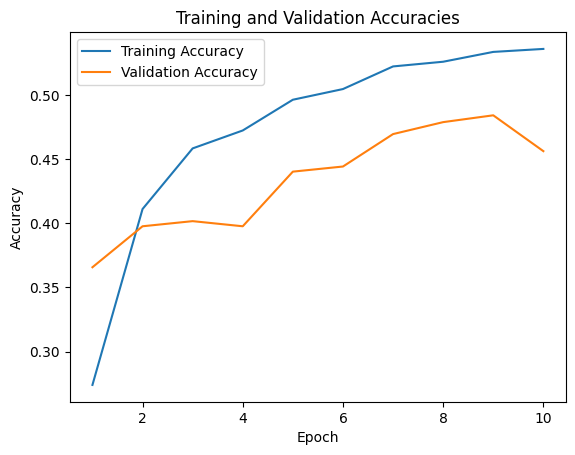

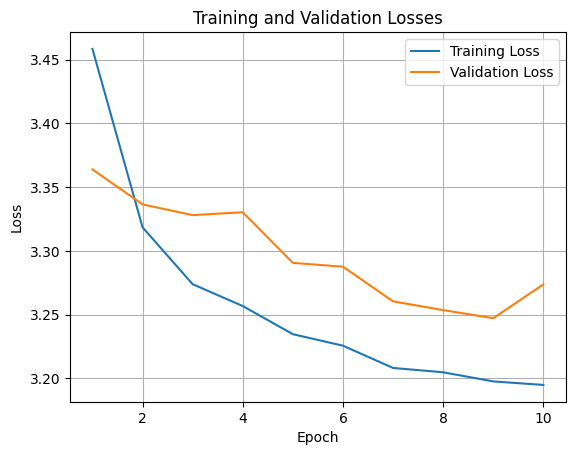

In [ ]:
trainModel(tuned_vgg16_model, 10)

In [ ]:
evalModel(tuned_vgg16_model, nn.CrossEntropyLoss())

Test Loss: 3.5159, Test Accuracy: 0.2098


#### VGG16_bn

##### Load Model

In [ ]:
default_weight_vgg16_bn = models.VGG16_BN_Weights.DEFAULT
vgg16_bn_model = models.vgg16_bn(weights=default_weight_vgg16_bn)

In [ ]:
for param in vgg16_bn_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg16_bn_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg16_bn_model = vgg16_bn_model

tuned_vgg16_bn_model.classifier = new_head

In [ ]:
print(tuned_vgg16_bn_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

##### Training

Epoch [1/10], Train Loss: 3.4629, Train Accuracy: 0.2757, Val Loss: 3.3139, Val Accuracy: 0.4229
Epoch [2/10], Train Loss: 3.2583, Train Accuracy: 0.4759, Val Loss: 3.2513, Val Accuracy: 0.4840
Epoch [3/10], Train Loss: 3.1917, Train Accuracy: 0.5394, Val Loss: 3.2139, Val Accuracy: 0.5186
Epoch [4/10], Train Loss: 3.1002, Train Accuracy: 0.6355, Val Loss: 3.1374, Val Accuracy: 0.5944
Epoch [5/10], Train Loss: 3.0566, Train Accuracy: 0.6758, Val Loss: 3.1096, Val Accuracy: 0.6237
Epoch [6/10], Train Loss: 3.0413, Train Accuracy: 0.6901, Val Loss: 3.0965, Val Accuracy: 0.6343
Epoch [7/10], Train Loss: 3.0333, Train Accuracy: 0.6974, Val Loss: 3.1054, Val Accuracy: 0.6263
Epoch [8/10], Train Loss: 3.0174, Train Accuracy: 0.7130, Val Loss: 3.1008, Val Accuracy: 0.6290
Epoch [9/10], Train Loss: 3.0117, Train Accuracy: 0.7200, Val Loss: 3.0975, Val Accuracy: 0.6356
Epoch [10/10], Train Loss: 3.0065, Train Accuracy: 0.7243, Val Loss: 3.0803, Val Accuracy: 0.6489


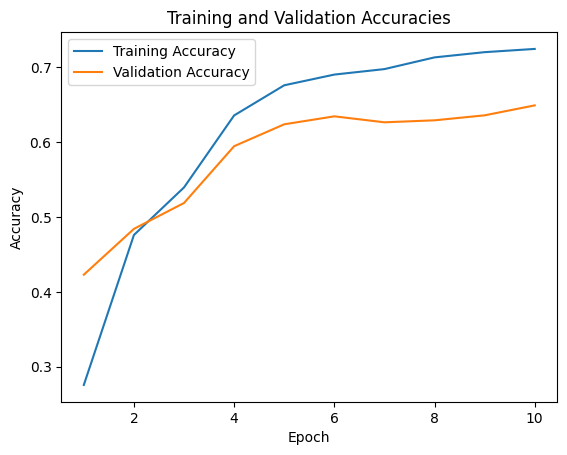

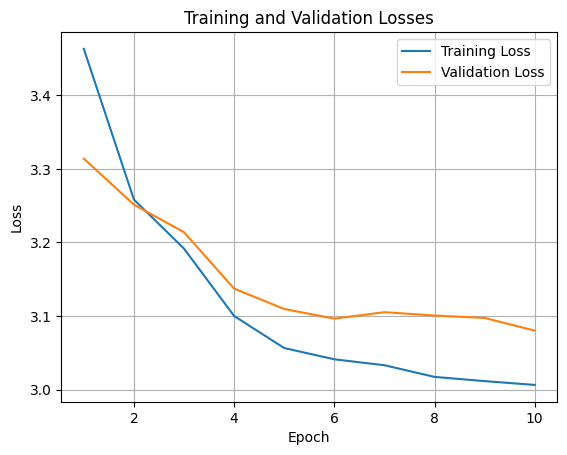

In [ ]:
trainModel(tuned_vgg16_bn_model, 10)

In [ ]:
evalModel(tuned_vgg16_bn_model, nn.CrossEntropyLoss())

Test Loss: 3.5355, Test Accuracy: 0.1958


#### VGG19

##### Load Model

In [ ]:
default_weight_vgg19 = models.VGG19_Weights.DEFAULT
vgg19_model = models.vgg19(weights=default_weight_vgg19)

In [ ]:
for param in vgg19_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg19_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg19_model = vgg19_model

tuned_vgg19_model.classifier = new_head

In [ ]:
print(tuned_vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

##### Training

Epoch [1/10], Train Loss: 3.4492, Train Accuracy: 0.2837, Val Loss: 3.3868, Val Accuracy: 0.3457
Epoch [2/10], Train Loss: 3.3466, Train Accuracy: 0.3834, Val Loss: 3.3768, Val Accuracy: 0.3537
Epoch [3/10], Train Loss: 3.3280, Train Accuracy: 0.4014, Val Loss: 3.3378, Val Accuracy: 0.3923
Epoch [4/10], Train Loss: 3.2945, Train Accuracy: 0.4363, Val Loss: 3.3004, Val Accuracy: 0.4309
Epoch [5/10], Train Loss: 3.2564, Train Accuracy: 0.4732, Val Loss: 3.2894, Val Accuracy: 0.4415
Epoch [6/10], Train Loss: 3.2391, Train Accuracy: 0.4919, Val Loss: 3.2896, Val Accuracy: 0.4415
Epoch [7/10], Train Loss: 3.2384, Train Accuracy: 0.4919, Val Loss: 3.2735, Val Accuracy: 0.4561
Epoch [8/10], Train Loss: 3.2233, Train Accuracy: 0.5075, Val Loss: 3.2694, Val Accuracy: 0.4588
Epoch [9/10], Train Loss: 3.2196, Train Accuracy: 0.5108, Val Loss: 3.2834, Val Accuracy: 0.4468
Epoch [10/10], Train Loss: 3.2114, Train Accuracy: 0.5191, Val Loss: 3.2460, Val Accuracy: 0.4840


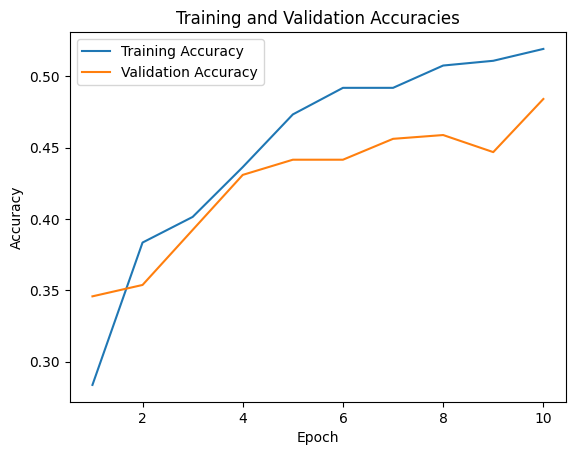

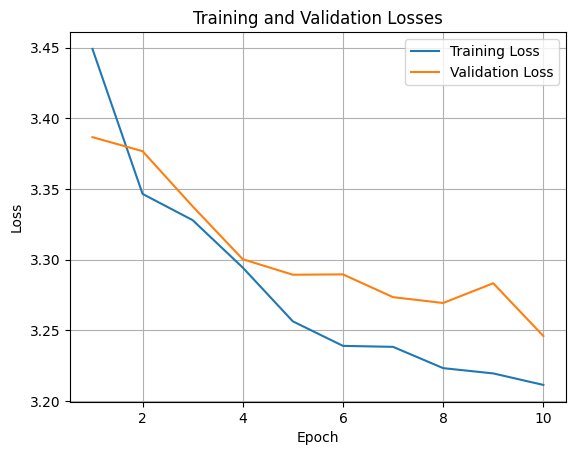

In [ ]:
trainModel(tuned_vgg19_model, 10)

In [ ]:
evalModel(tuned_vgg19_model, nn.CrossEntropyLoss())

Test Loss: 3.5724, Test Accuracy: 0.1608


#### VGG19_bn

##### Load Model

In [ ]:
default_weight_vgg19_bn = models.VGG19_BN_Weights.DEFAULT
vgg19_bn_model = models.vgg19_bn(weights=default_weight_vgg19_bn)

In [ ]:
for param in vgg19_bn_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg19_bn_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg19_bn_model = vgg19_bn_model

tuned_vgg19_bn_model.classifier = new_head

In [ ]:
print(tuned_vgg19_bn_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

##### Training

In [ ]:
trainModel(tuned_vgg19_bn_model, 10)

KeyboardInterrupt: 

In [ ]:
evalModel(tuned_vgg19_bn_model, nn.CrossEntropyLoss())

## VisionTransformer

### Models

#### Vit_b_16

##### Load Model

In [ ]:
default_weight_vit_b_16 = models.ViT_B_16_Weights.DEFAULT
vit_b_16_model = models.vit_b_16(weights=default_weight_vit_b_16)

In [ ]:
for param in vit_b_16_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vit_b_16_model.heads.head.in_features

new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_vit_b_16_model = vit_b_16_model

tuned_vit_b_16_model.heads = new_head

In [ ]:
print(tuned_vit_b_16_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 3.3130, Train Accuracy: 0.4779, Val Loss: 3.1425, Val Accuracy: 0.5944
Epoch [2/10], Train Loss: 3.0743, Train Accuracy: 0.6651, Val Loss: 3.0910, Val Accuracy: 0.6410
Epoch [3/10], Train Loss: 3.0138, Train Accuracy: 0.7220, Val Loss: 3.0225, Val Accuracy: 0.7114
Epoch [4/10], Train Loss: 2.9743, Train Accuracy: 0.7596, Val Loss: 3.0084, Val Accuracy: 0.7274
Epoch [5/10], Train Loss: 2.9494, Train Accuracy: 0.7825, Val Loss: 3.0071, Val Accuracy: 0.7261
Epoch [6/10], Train Loss: 2.9478, Train Accuracy: 0.7855, Val Loss: 3.0011, Val Accuracy: 0.7314
Epoch [7/10], Train Loss: 2.9408, Train Accuracy: 0.7898, Val Loss: 2.9957, Val Accuracy: 0.7394
Epoch [8/10], Train Loss: 2.9371, Train Accuracy: 0.7935, Val Loss: 2.9927, Val Accuracy: 0.7460
Epoch [9/10], Train Loss: 2.9332, Train Accuracy: 0.7985, Val Loss: 2.9914, Val Accuracy: 0.7434
Epoch [10/10], Train Loss: 2.9269, Train Accuracy: 0.8051, Val Loss: 2.9836, Val Accuracy: 0.7513


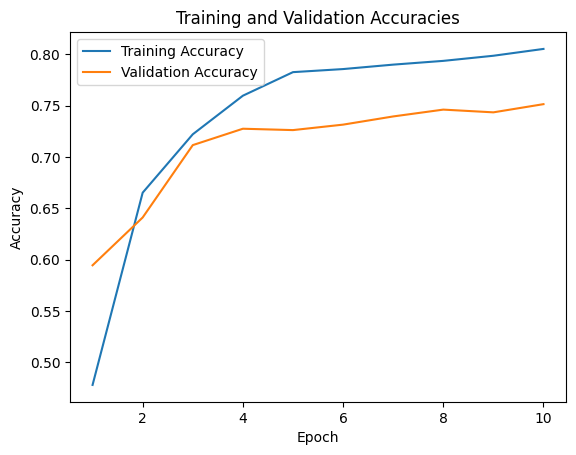

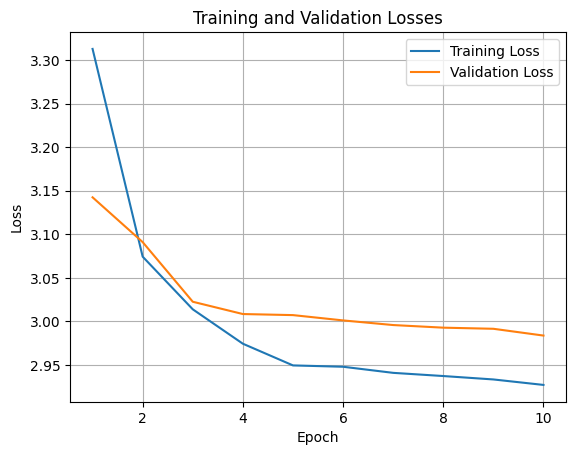

In [ ]:
trainModel(tuned_vit_b_16_model, 10)

In [ ]:
evalModel(tuned_vit_b_16_model, nn.CrossEntropyLoss())

#### Vit_b_32

##### Load Model

In [ ]:
default_weight_vit_b_32 = models.ViT_B_32_Weights.DEFAULT
vit_b_32_model = models.vit_b_32(weights=default_weight_vit_b_32)

In [ ]:
for param in vit_b_32_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vit_b_32_model.heads.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vit_b_32_model = vit_b_32_model

tuned_vit_b_32_model.heads = new_head

In [ ]:
print(tuned_vit_b_32_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

##### Training

In [ ]:
trainModel(tuned_vit_b_32_model, 10)

In [ ]:
evalModel(tuned_vit_b_32_model, nn.CrossEntropyLoss())

#### Vit_l_16

##### Load Model

In [ ]:
default_weight_vit_l_16 = models.ViT_L_16_Weights.DEFAULT
vit_l_16_model = models.vit_l_16(weights=default_weight_vit_l_16)

Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\vit_l_16-852ce7e3.pth
100%|██████████| 1.13G/1.13G [01:33<00:00, 13.0MB/s]


In [ ]:
for param in vit_l_16_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vit_l_16_model.heads.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vit_l_16_model = vit_l_16_model

tuned_vit_l_16_model.heads = new_head

##### Training

In [ ]:
trainModel(tuned_vit_l_16_model, 10)

In [ ]:
evalModel(tuned_vit_l_16_model, nn.CrossEntropyLoss())

#### Vit_l_32

##### Load Model

In [ ]:
default_weight_vit_l_32 = models.ViT_L_32_Weights.DEFAULT
vit_l_32_model = models.vit_l_32(weights=default_weight_vit_l_32)

Downloading: "https://download.pytorch.org/models/vit_l_32-c7638314.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\vit_l_32-c7638314.pth
100%|██████████| 1.14G/1.14G [01:34<00:00, 13.0MB/s]


In [ ]:
for param in vit_l_32_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vit_l_32_model.heads.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vit_l_32_model = vit_l_32_model

tuned_vit_l_32_model.heads = new_head

In [ ]:
print(tuned_vit_l_32_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

##### Training

In [ ]:
trainModel(tuned_vit_l_32_model, 10)

In [ ]:
evalModel(tuned_vit_l_32_model, nn.CrossEntropyLoss())

#### Vit_h_14

##### Load Model

In [ ]:
default_weight_vit_h_14 = models.ViT_H_14_Weights.DEFAULT
vit_h_14_model = models.vit_h_14(weights=default_weight_vit_h_14)

Downloading: "https://download.pytorch.org/models/vit_h_14_swag-80465313.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\vit_h_14_swag-80465313.pth
100%|██████████| 2.36G/2.36G [03:24<00:00, 12.4MB/s] 


In [ ]:
for param in vit_h_14_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = vit_h_14_model.heads.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vit_h_14_model = vit_h_14_model

tuned_vit_h_14_model.heads = new_head

In [ ]:
print(tuned_vit_h_14_model)

##### Training

In [ ]:
trainModel(tuned_vit_h_14_model, 10)

In [ ]:
evalModel(tuned_vit_h_14_model, nn.CrossEntropyLoss())

## Wide ResNet

### Models

#### WideResNet50_2

##### Load Model

In [ ]:
default_weight_wide_resnet50_2 = models.Wide_ResNet50_2_Weights.DEFAULT
wide_resnet50_2_model = models.wide_resnet50_2(weights=default_weight_wide_resnet50_2)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\wide_resnet50_2-9ba9bcbe.pth
100%|██████████| 263M/263M [00:21<00:00, 13.1MB/s] 


In [ ]:
for param in wide_resnet50_2_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = wide_resnet50_2_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_wide_resnet50_2_model = wide_resnet50_2_model

tuned_wide_resnet50_2_model.fc = new_head

In [ ]:
print(tuned_wide_resnet50_2_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

##### Training

In [ ]:
trainModel(tuned_wide_resnet50_2_model, 10)

In [ ]:
evalModel(tuned_wide_resnet50_2_model, nn.CrossEntropyLoss())

#### WideResNet101_2

##### Load Model

In [ ]:
default_weight_wide_resnet101_2 = models.Wide_ResNet101_2_Weights.DEFAULT
wide_resnet101_2_model = models.wide_resnet101_2(weights=default_weight_wide_resnet101_2)

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-d733dc28.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\wide_resnet101_2-d733dc28.pth
100%|██████████| 485M/485M [00:40<00:00, 12.7MB/s]  


In [ ]:
for param in wide_resnet101_2_model.parameters():
    param.requires_grad = False

In [ ]:
num_features = wide_resnet101_2_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_wide_resnet101_2_model = wide_resnet101_2_model

tuned_wide_resnet101_2_model.fc = new_head

In [ ]:
print(tuned_wide_resnet101_2_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

##### Training

In [ ]:
trainModel(tuned_wide_resnet101_2_model, 10)

In [ ]:
evalModel(tuned_wide_resnet101_2_model, nn.CrossEntropyLoss())